# Imports

In [1]:
import PW_explorer as pwe
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.visualize import PWEVisualization
import pandas as pd
import numpy as np

# Boilerplate Visualization Code

In [2]:
# From stackoverflow
import matplotlib.pyplot as plt
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(120,20)):
    """
    Take in a list of images and display them in a grid of size $figsize with $no_of_columns columns.
    """
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [3]:
def display_viz(vizs, no_of_columns=6, figsize=(60,60)):
    """
    Display a list of networkx graphs and display them in a grid of size $figsize with $no_of_columns columns.
    """
    images = []
    for pw_id, viz in vizs.items():
        images.append(draw(viz))
    images = [plt.imread(im.filename) for im in images]
    grid_display(images, no_of_columns=no_of_columns, figsize=figsize)

## User-defined Visualization Function

Here we define our own visualization for the PWs

In [4]:
# More color schemes here: https://www.graphviz.org/doc/info/colors.html
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
def colorability_viz(pw_rels_dfs, pw_id, fill_type='filled', 
                     cmap={'red':1, 'blue':2, 'green':3}, colorscheme='pastel13', 
                     color_to_node_shape_map={'red': 'oval', 'blue': 'oval', 'green': 'oval'}, 
                     print_title=True):
    
    nodes_df = pw_rels_dfs['node_1']
    nodes_df = nodes_df[nodes_df['pw'] == pw_id]
    
    edges_df = pw_rels_dfs['e_2']
    edges_df = edges_df[edges_df['pw'] == pw_id]
    
    G = nx.Graph()
    if print_title:
        G.graph['label'] = 'PW_{}'.format(pw_id)
    G.graph['layout'] = 'neato'
    G.add_nodes_from(list(nodes_df['nodeID']), style=fill_type, colorscheme=colorscheme, 
                     fontname='Helvetica')
    G.add_edges_from(zip(list(edges_df['nodeID1']), list(edges_df['nodeID2'])))
    
    if 'col_2' in pw_rels_dfs:
        colors_df = pw_rels_dfs['col_2']
        colors_df = colors_df[colors_df['pw'] == pw_id]
        for _, row in colors_df.iterrows():
            G.nodes[row['nodeID']]['fillcolor'] = cmap[row['color']]
            G.nodes[row['nodeID']]['shape'] = color_to_node_shape_map[row['color']]
    
    return G

Here we define a custom cluster-map visualization that leverages the seaborn library.

Uncomment the line below to install the seaborn package that is required by this function.
(Try pip instead of pip3 if the below fails)

In [5]:
#!pip3 install seaborn

In [6]:
import seaborn as sns
def cluster_map_viz(dist_matrix):
    t = pd.DataFrame(dist_matrix)
    t = t.rename(lambda x: x+1, axis='index')
    t = t.rename(lambda x: x+1, axis='columns')
    cluster_map = sns.clustermap(t, cmap="mako")
    fig = cluster_map.fig
    plt.show()
    return fig

# Experiment

We begin by taking a look at the ASP formulation of a small graph.

We store these rules in the 'graph_instance' variable as a list of strings

In [7]:
with open('clingo_files/3col_instance.lp4') as f:
    graph_instance = list(map(str.strip, f.readlines()))
print("\n".join(graph_instance))

% -*- Mode: Prolog -*-
% define node(nodeID)
% define e(nodeID1, nodeID2)
node(1..5).  e(1,2). e(2,3). e(3,4). e(4,1). e(4,5).  % a small sample graph


In [8]:
clingo_soln, meta_data = run_clingo(clingo_rules=graph_instance)
pw_rel_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


This is what the graph looks like.

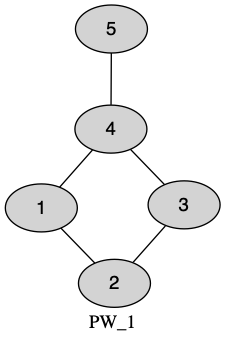

In [9]:
input_viz = colorability_viz(pw_rel_dfs, 1, fill_type='filled')
draw(input_viz)

In [10]:
# Uncomment lines below to save the above visualization
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(input_viz, format=f, filename='3col_input.{}'.format(f), show='none')

Looks pretty dull! So, now let's 3 color it!

#### Here's the rules for the 3-coloring problem:

In [11]:
with open('clingo_files/3col_enc.lp4') as f:
    col_enc_rules = list(map(str.strip, f.readlines()))
print("\n".join(col_enc_rules))

% -*- Mode: Prolog -*-
% define col(nodeID, color)
col(X,red) ; col(X,green) ; col(X,blue) :- node(X).   % .. with choice rule to generate colorings
:- e(X,Y), col(X,C), col(Y,C), X != Y.                % .. and IC: no neighbors with same color!


Now we combine the two sets of rules to create the 3 colorings of this graph

In [12]:
clingo_rules = graph_instance + col_enc_rules
print("\n".join(clingo_rules))

% -*- Mode: Prolog -*-
% define node(nodeID)
% define e(nodeID1, nodeID2)
node(1..5).  e(1,2). e(2,3). e(3,4). e(4,1). e(4,5).  % a small sample graph
% -*- Mode: Prolog -*-
% define col(nodeID, color)
col(X,red) ; col(X,green) ; col(X,blue) :- node(X).   % .. with choice rule to generate colorings
:- e(X,Y), col(X,C), col(Y,C), X != Y.                % .. and IC: no neighbors with same color!


In [13]:
# Filter out comments
clingo_rules_ = list(filter(lambda x: len(x) > 0 and x[0] != '%', clingo_rules))

In [14]:
print("\n".join(clingo_rules_))

node(1..5).  e(1,2). e(2,3). e(3,4). e(4,1). e(4,5).  % a small sample graph
col(X,red) ; col(X,green) ; col(X,blue) :- node(X).   % .. with choice rule to generate colorings
:- e(X,Y), col(X,C), col(Y,C), X != Y.                % .. and IC: no neighbors with same color!


In [15]:
# We append this rule so only the coloring is shown in the solution below. Else the solution is hard to read.
clingo_rules.append('#show col/2.')

Using the run_clingo function, which runs the clingo solver (and also detects the custom %define syntax as can be seen in the clingo program above.), we get 36 PWs.

In [16]:
clingo_soln, meta_data = run_clingo(clingo_rules=clingo_rules)
print('\n'.join(clingo_soln))

Answer: 1
col(1,blue) col(2,red) col(3,green) col(4,red) col(5,blue)
Answer: 2
col(1,blue) col(2,red) col(3,green) col(4,red) col(5,green)
Answer: 3
col(1,green) col(2,red) col(3,green) col(4,red) col(5,blue)
Answer: 4
col(1,green) col(2,red) col(3,green) col(4,red) col(5,green)
Answer: 5
col(1,green) col(2,blue) col(3,green) col(4,red) col(5,blue)
Answer: 6
col(1,green) col(2,blue) col(3,green) col(4,red) col(5,green)
Answer: 7
col(1,blue) col(2,red) col(3,blue) col(4,red) col(5,blue)
Answer: 8
col(1,blue) col(2,red) col(3,blue) col(4,red) col(5,green)
Answer: 9
col(1,green) col(2,red) col(3,blue) col(4,red) col(5,blue)
Answer: 10
col(1,green) col(2,red) col(3,blue) col(4,red) col(5,green)
Answer: 11
col(1,blue) col(2,green) col(3,blue) col(4,red) col(5,blue)
Answer: 12
col(1,blue) col(2,green) col(3,blue) col(4,red) col(5,green)
Answer: 13
col(1,green) col(2,red) col(3,green) col(4,blue) col(5,red)
Answer: 14
col(1,green) col(2,red) col(3,green) col(4,blue) col(5,green)
Answer: 15
co

The meta_data is helpful to store information about the problem detected by PWE through special syntax like '% define'

In [17]:
meta_data

{'attr_defs': {'node_1': ['nodeID'],
  'e_2': ['nodeID1', 'nodeID2'],
  'col_2': ['nodeID', 'color']},
 'temporal_decs': {}}

In [18]:
clingo_soln, meta_data = run_clingo(clingo_rules=clingo_rules[:-1])

From the solution of the above program, we extract the solutions and load the PWs into RDBMS-style Panda Dataframes

In [19]:
pw_rel_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 36


These are the atom types that were detected. They are stored as "atomName_arity"

In [20]:
pw_rel_dfs.keys()

dict_keys(['node_1', 'e_2', 'col_2'])

This is what the Pandas Dataframe for the 'col' relation (with arity 2) looks like.

In [21]:
pw_rel_dfs['col_2']

,pw,nodeID,color
0,1,1,blue
1,1,2,red
2,1,3,green
3,1,4,red
4,1,5,blue
5,2,1,blue
6,2,2,red
7,2,3,green
8,2,4,red
9,2,5,green


## Visualization
Now we can create the visualizations for these PWs using the custom visualization we defined above

In [22]:
vizs = {pw_id: colorability_viz(pw_rel_dfs, pw_id, fill_type='filled', 
                                cmap={'red': 1, 'blue':2, 'green':3}, colorscheme='pastel13') 
        for pw_id in range(1, len(pw_objs)+1)}

Now we can draw them one at a time

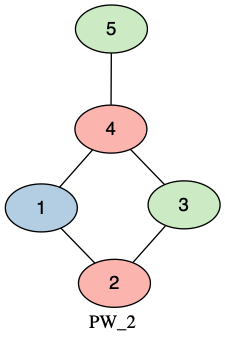

In [23]:
draw(vizs[2])

##### Or draw them all together i.e. the Worlds View

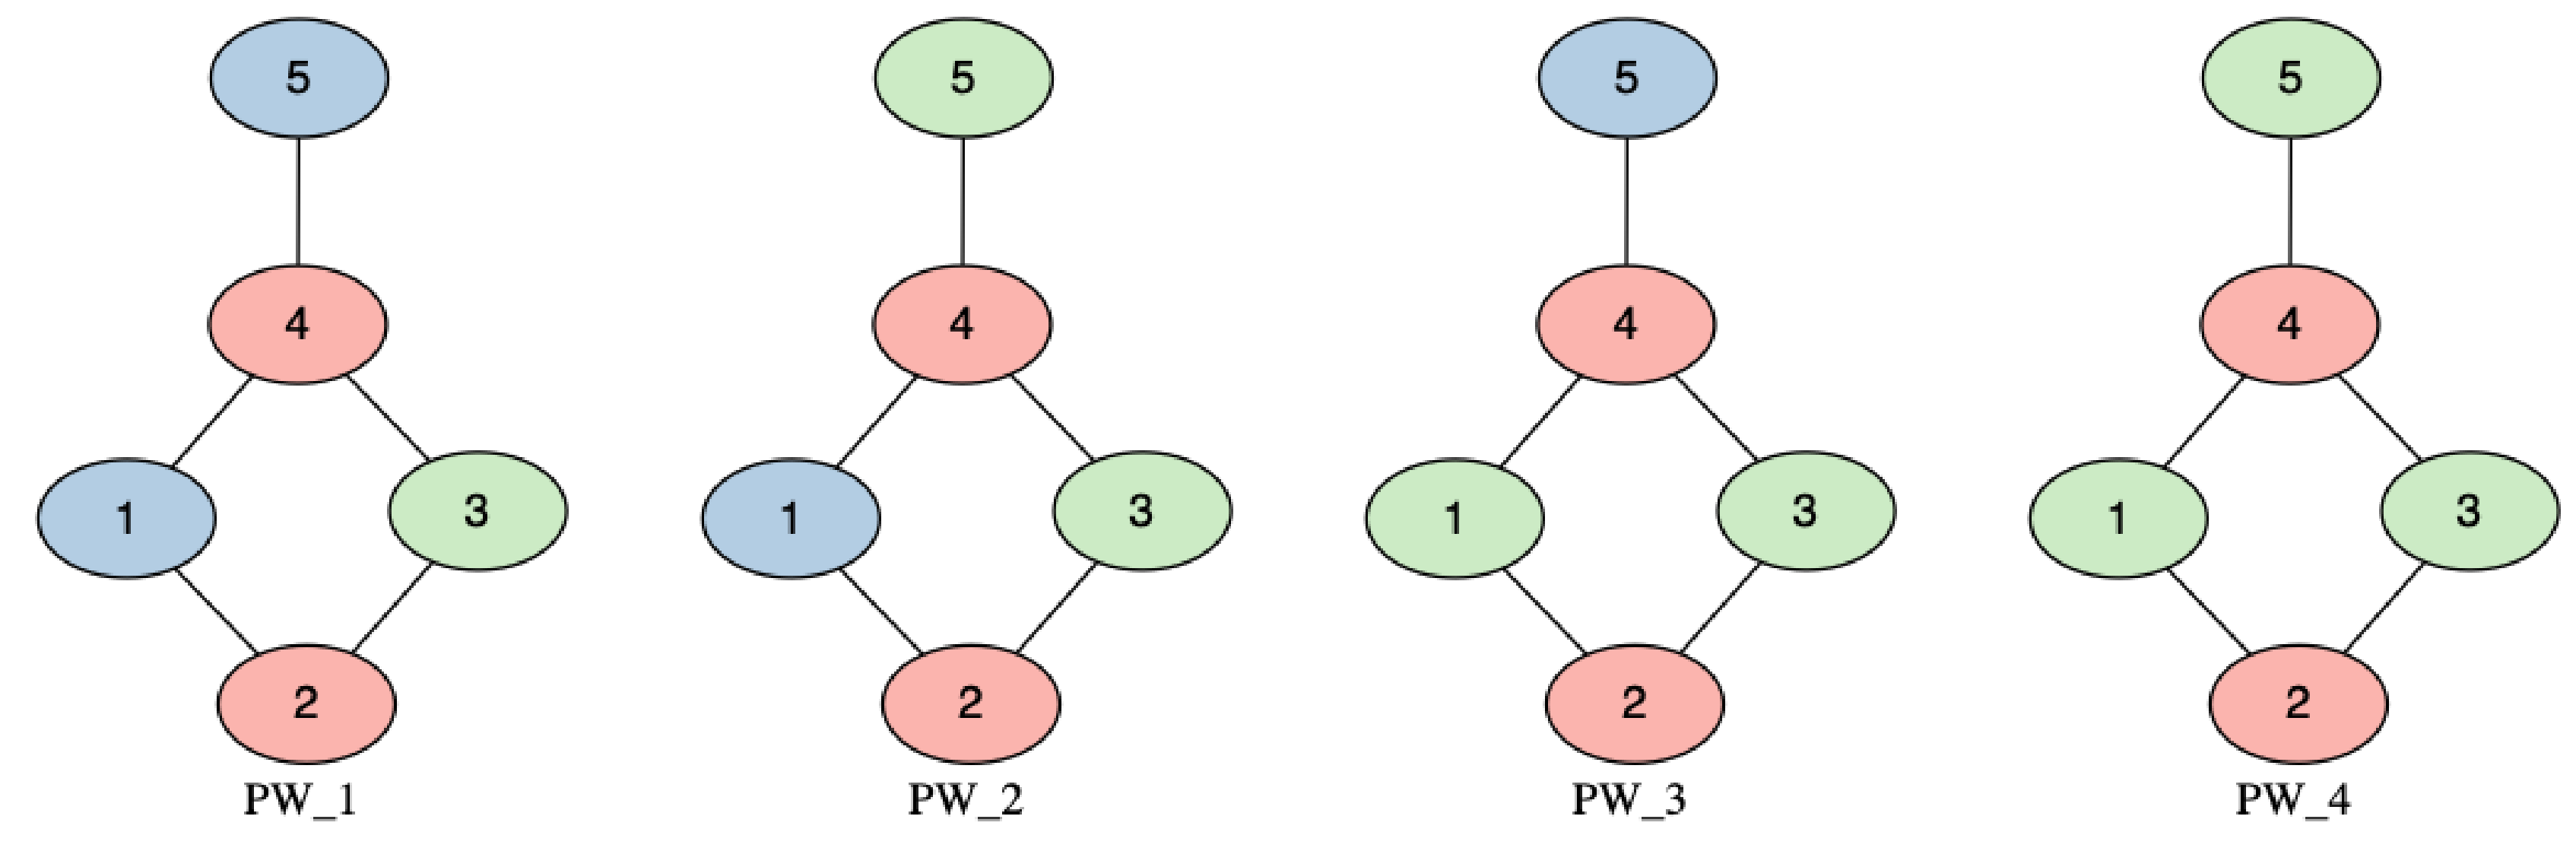

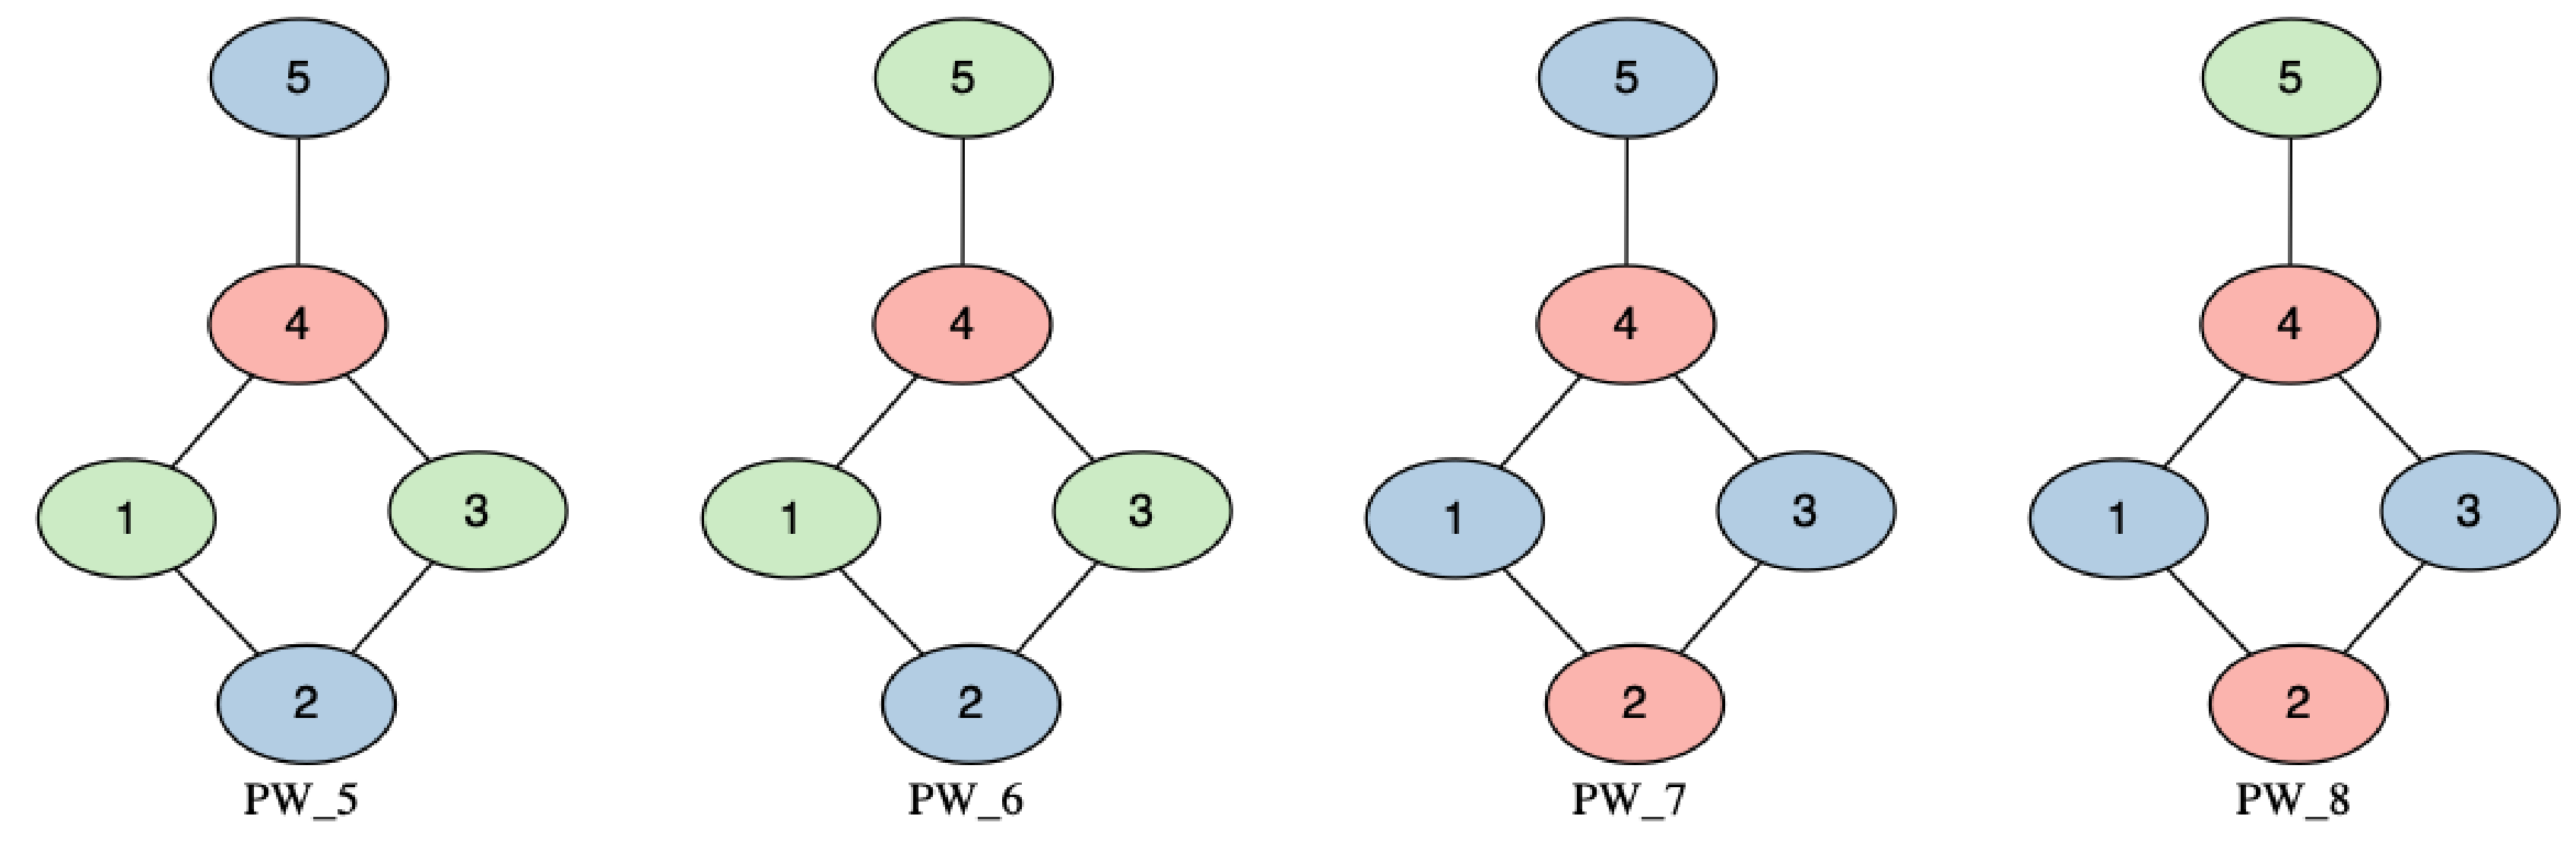

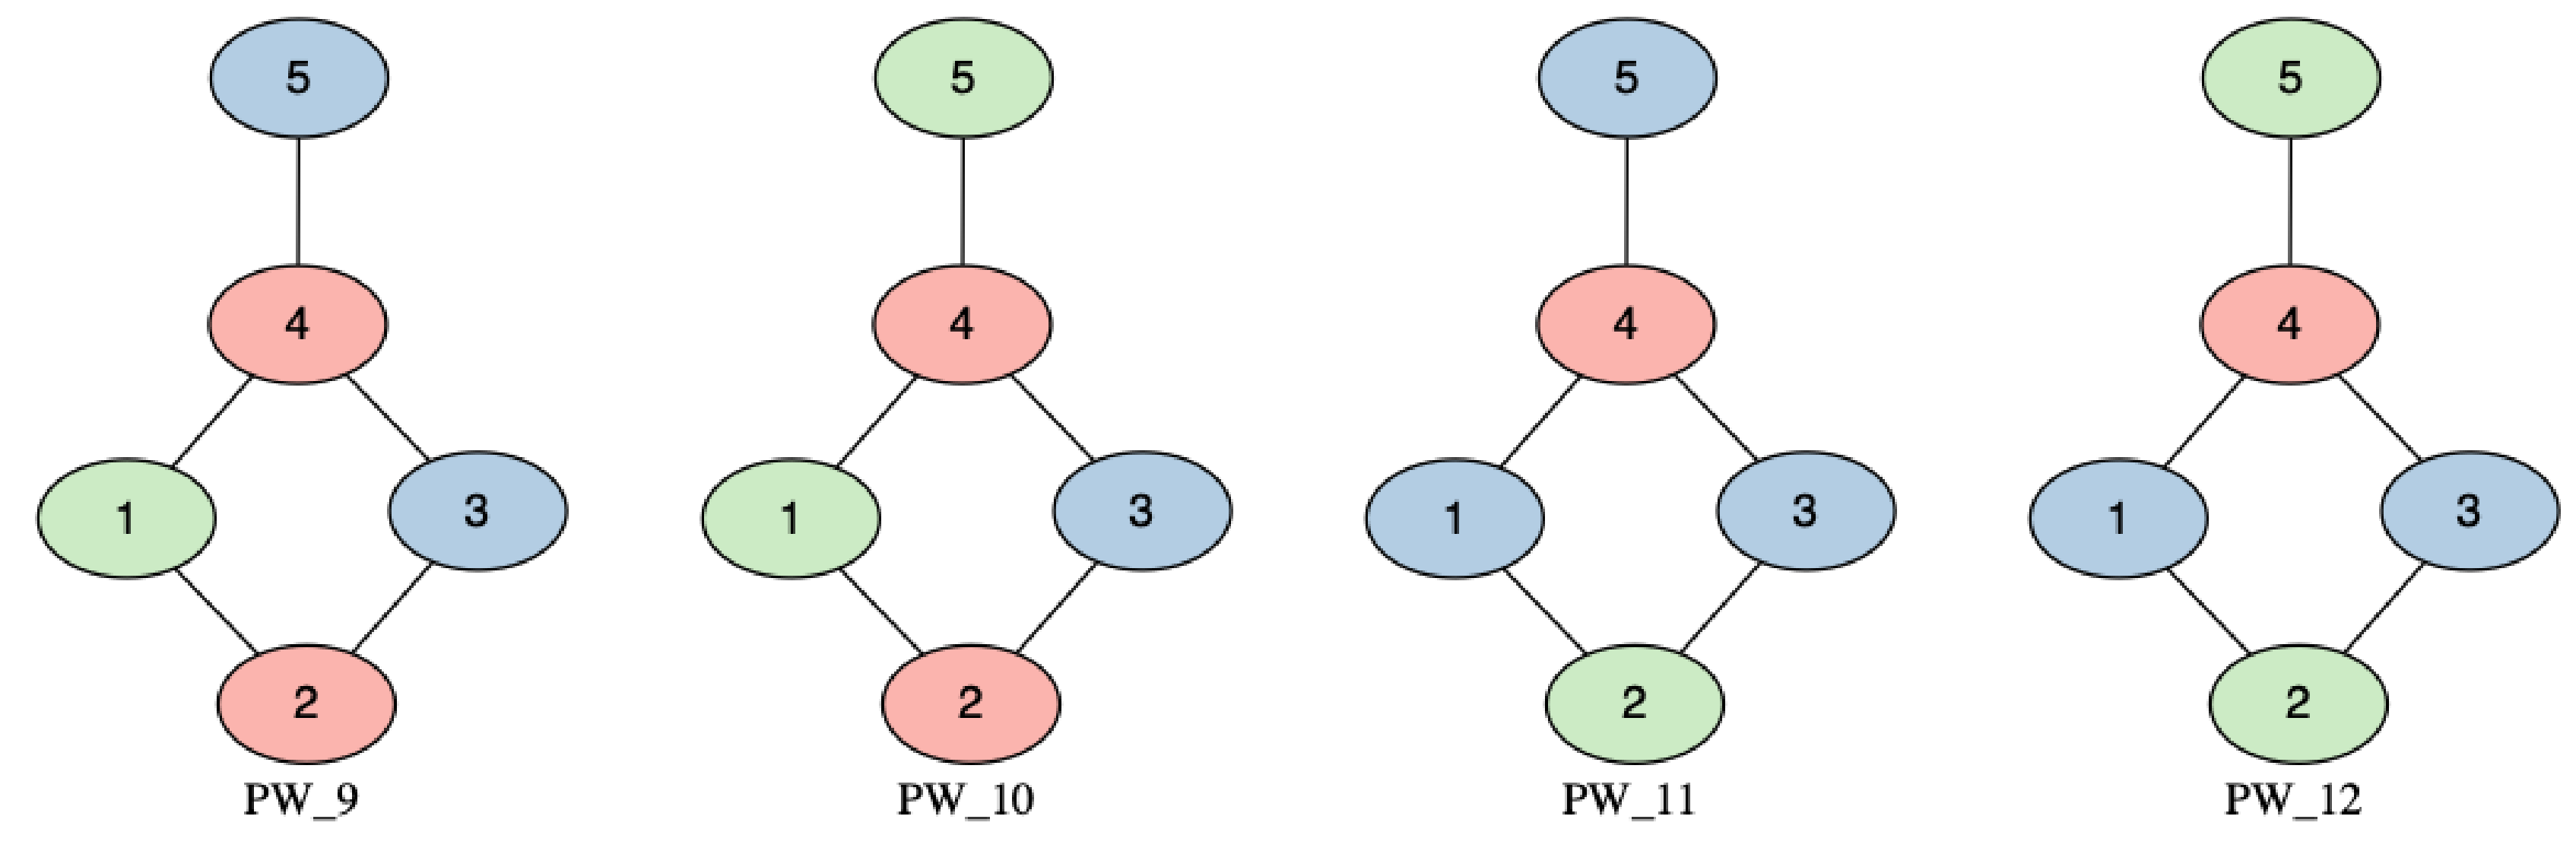

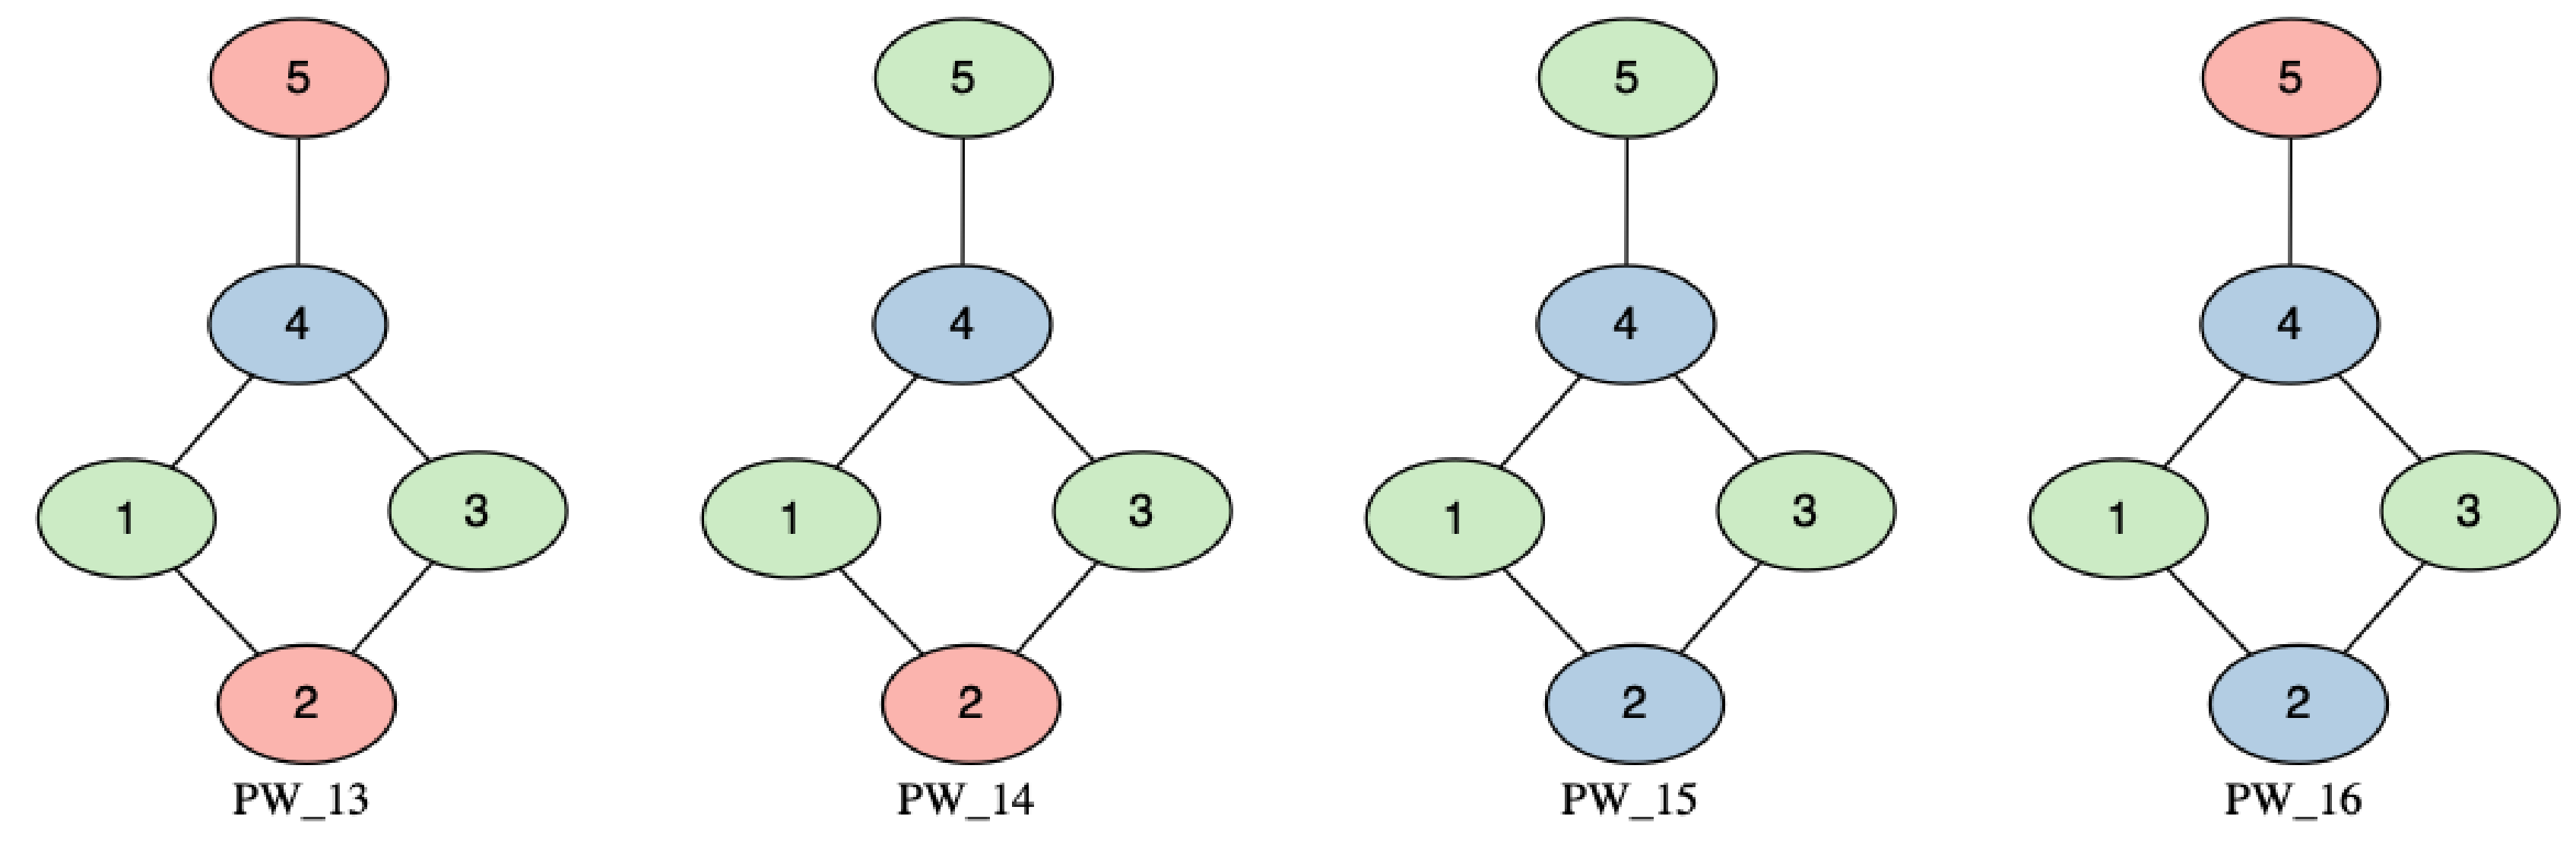

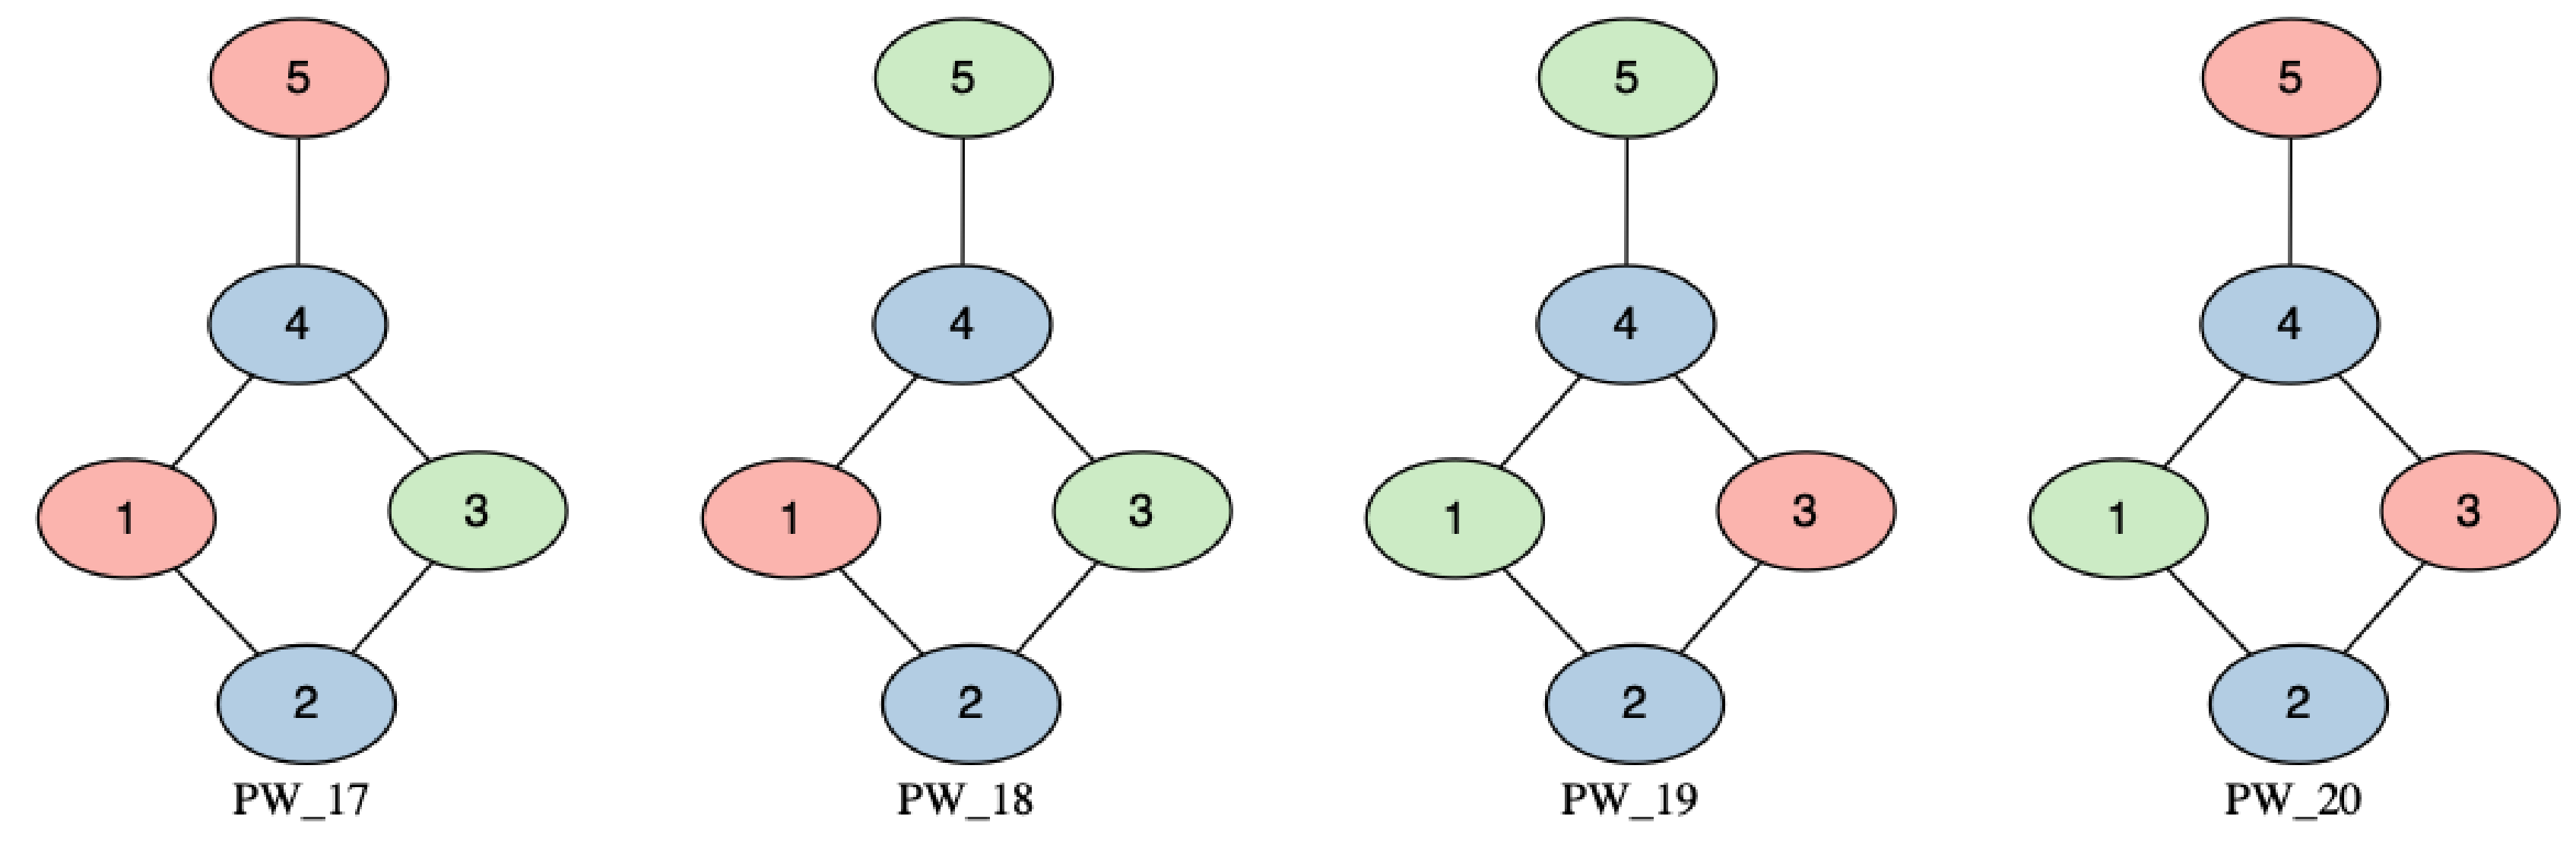

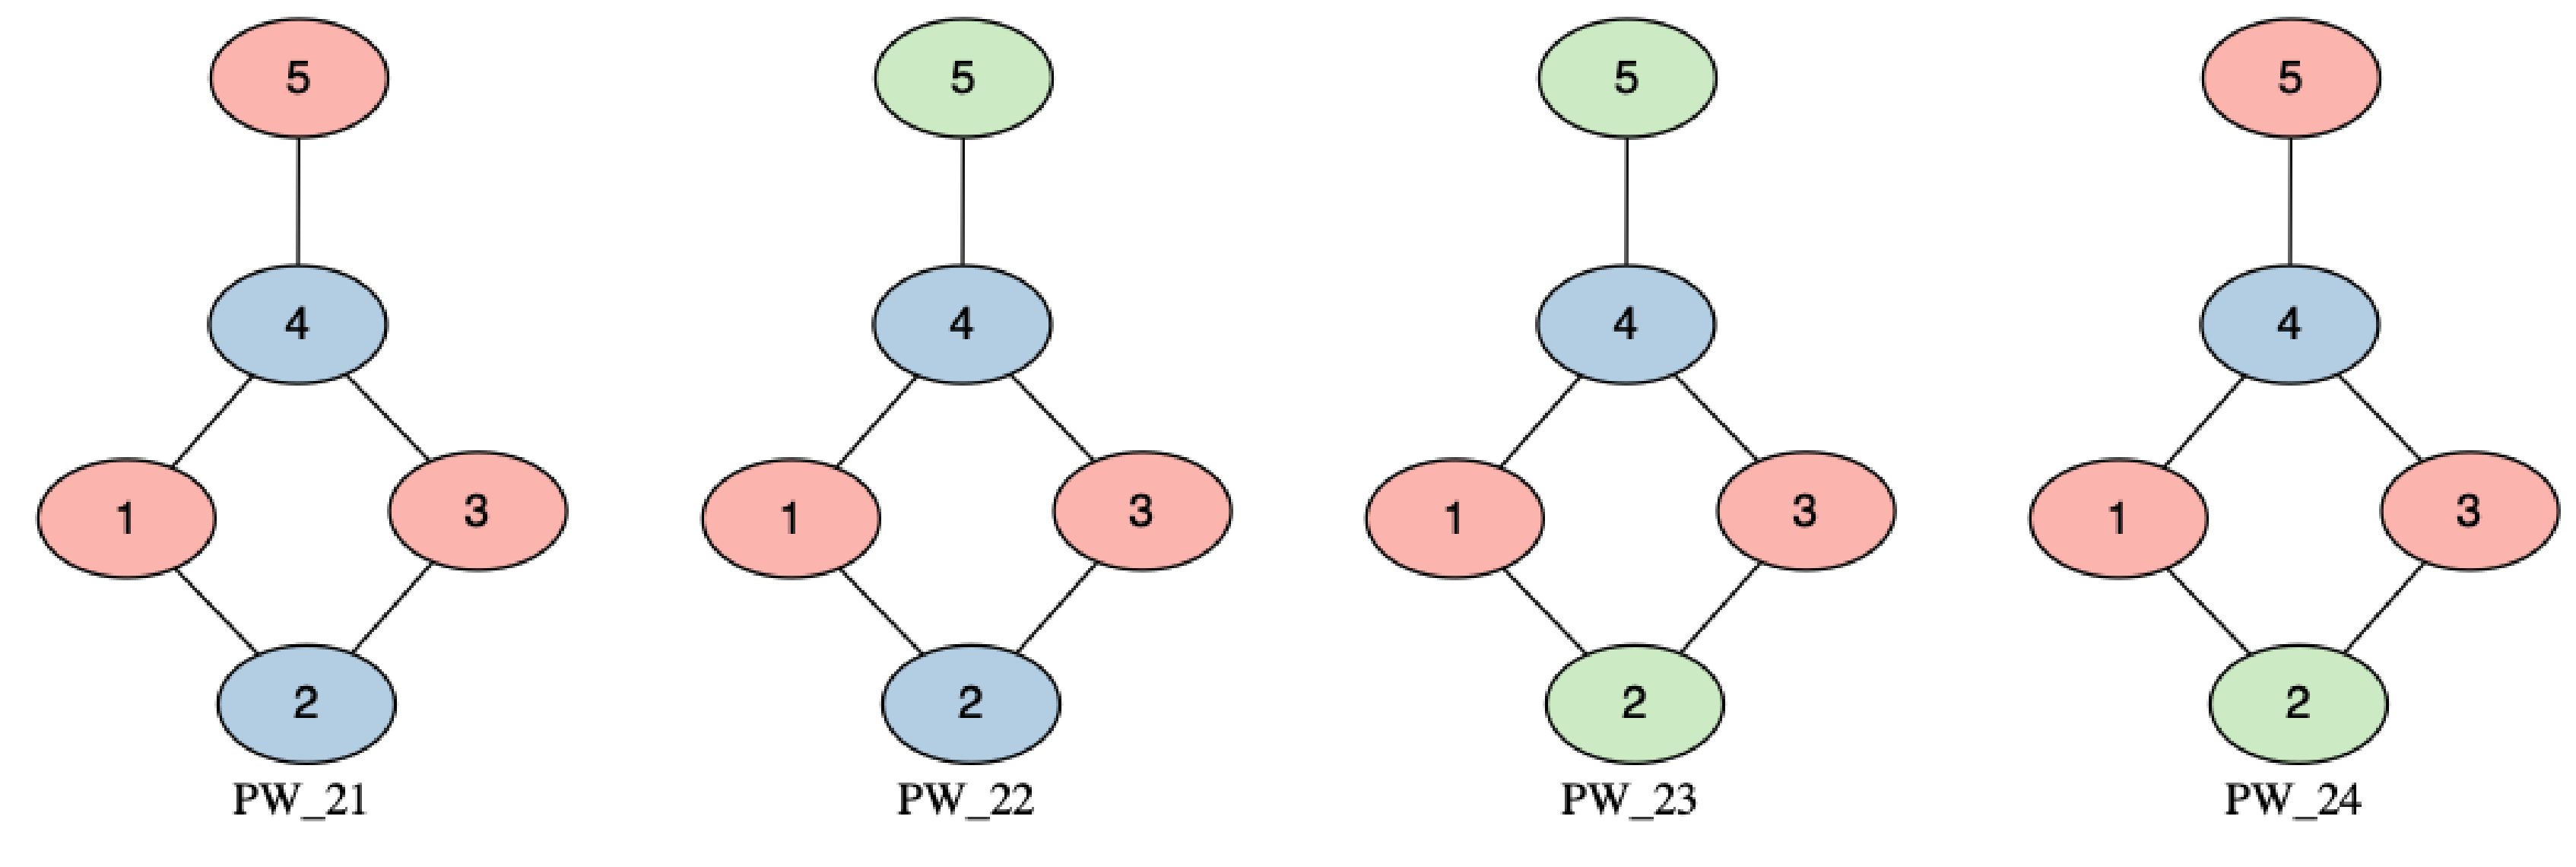

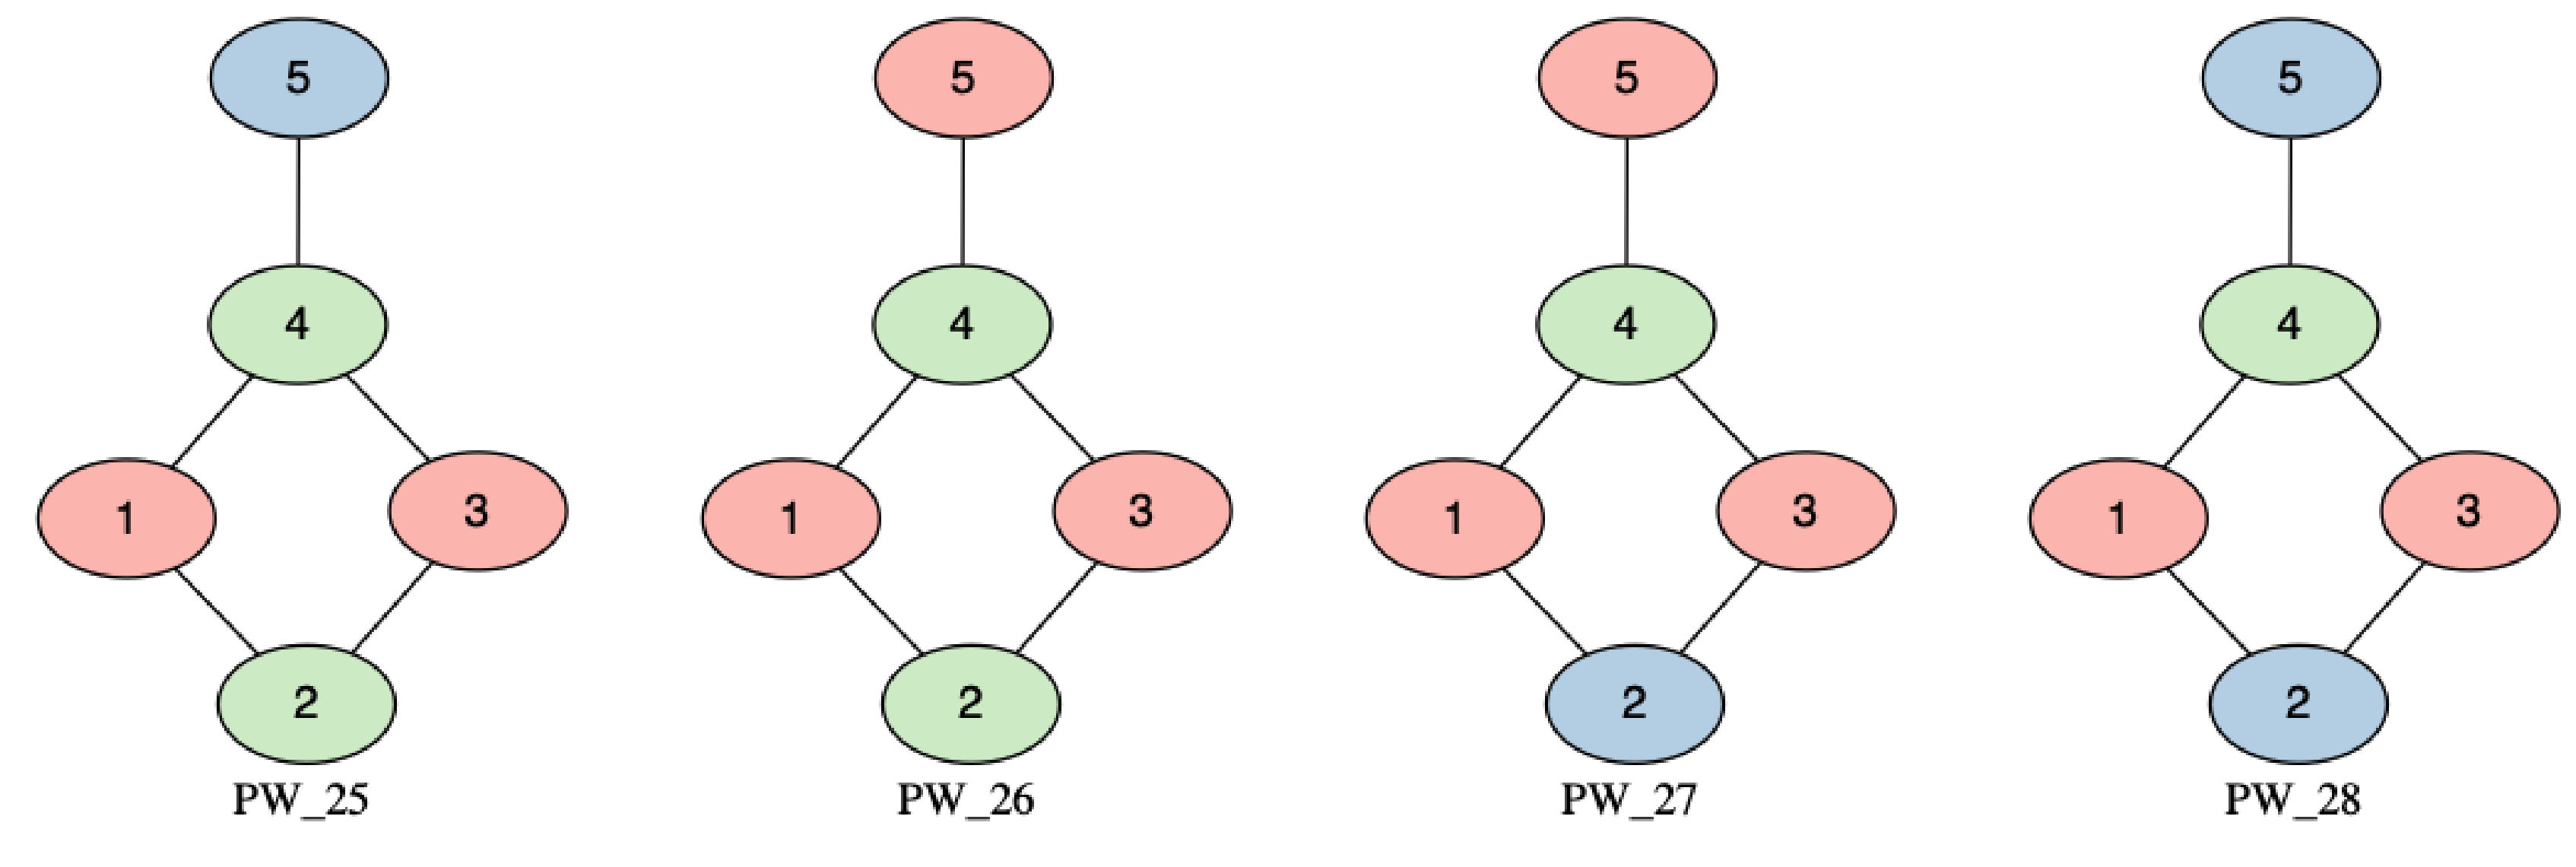

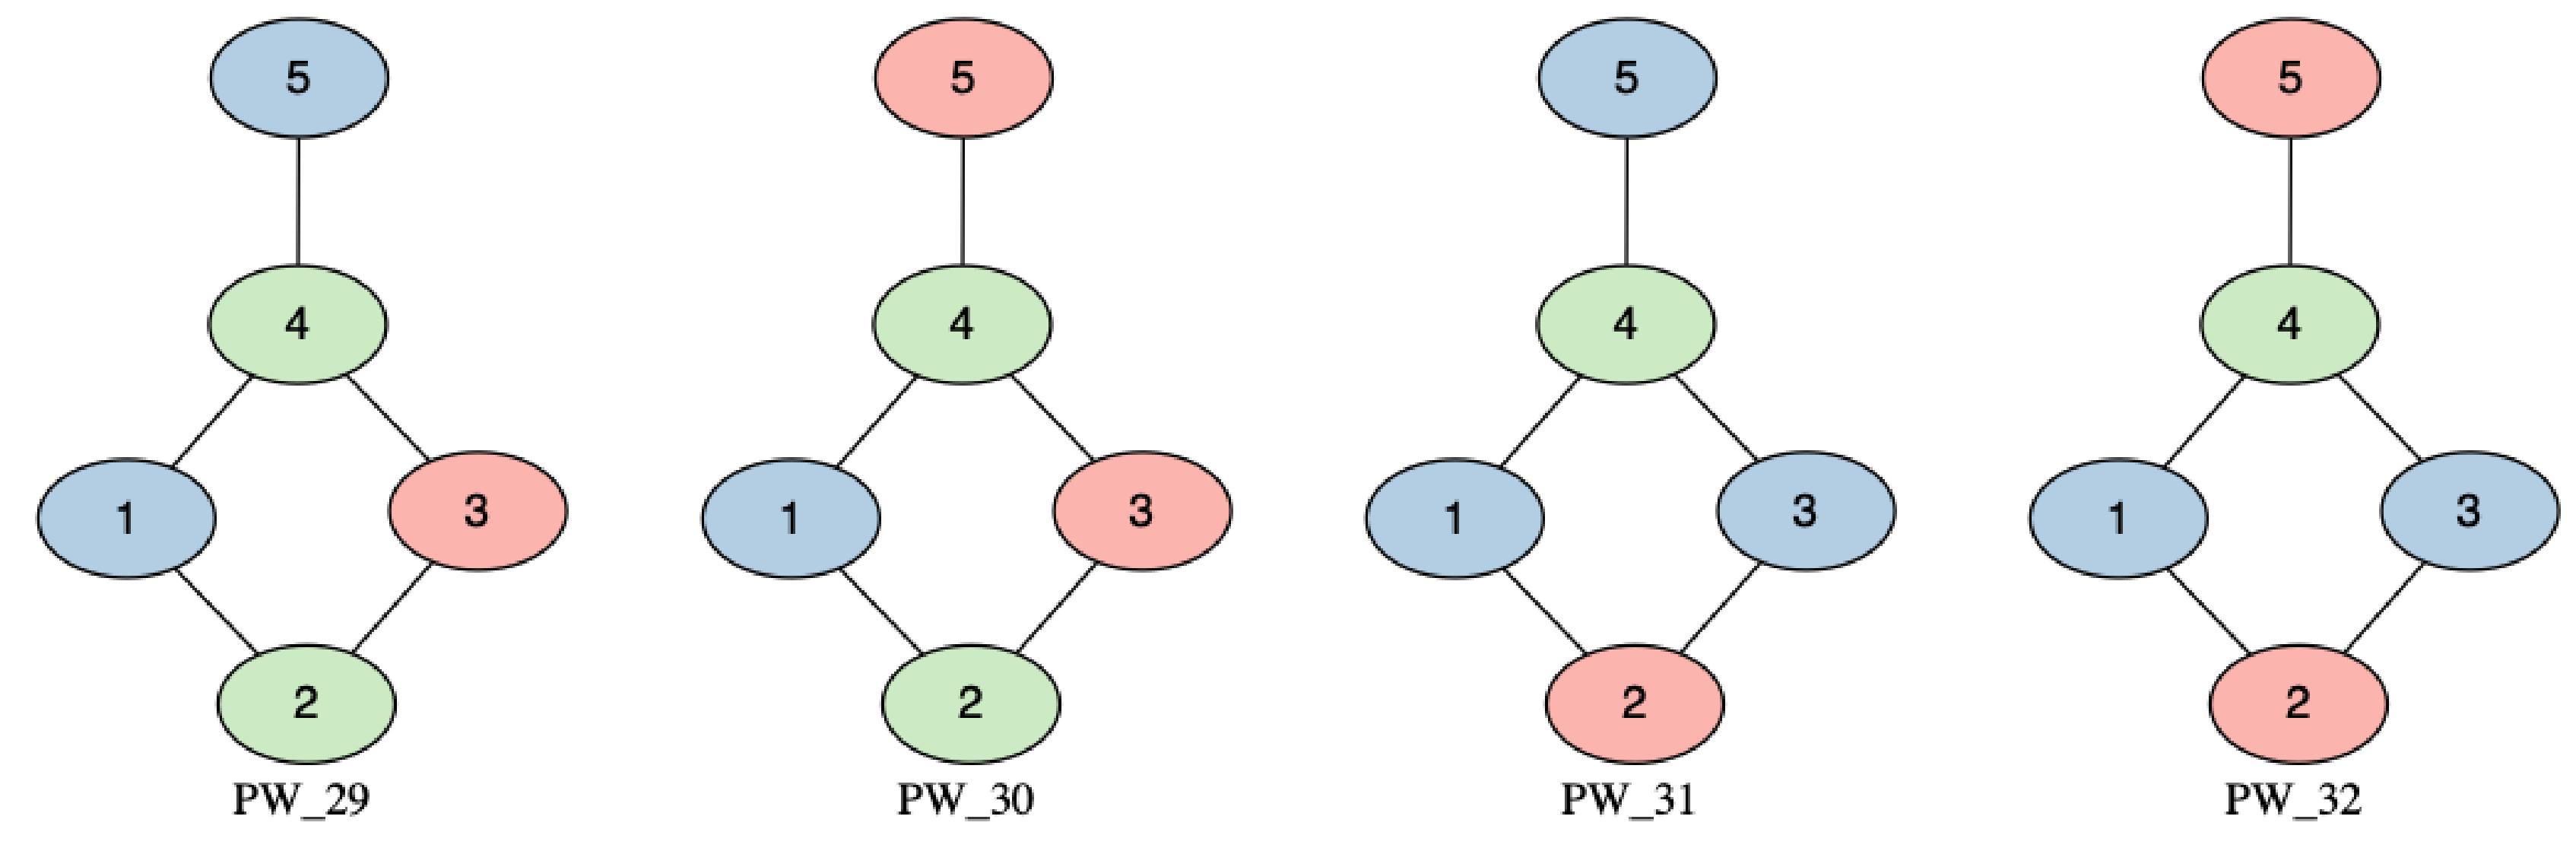

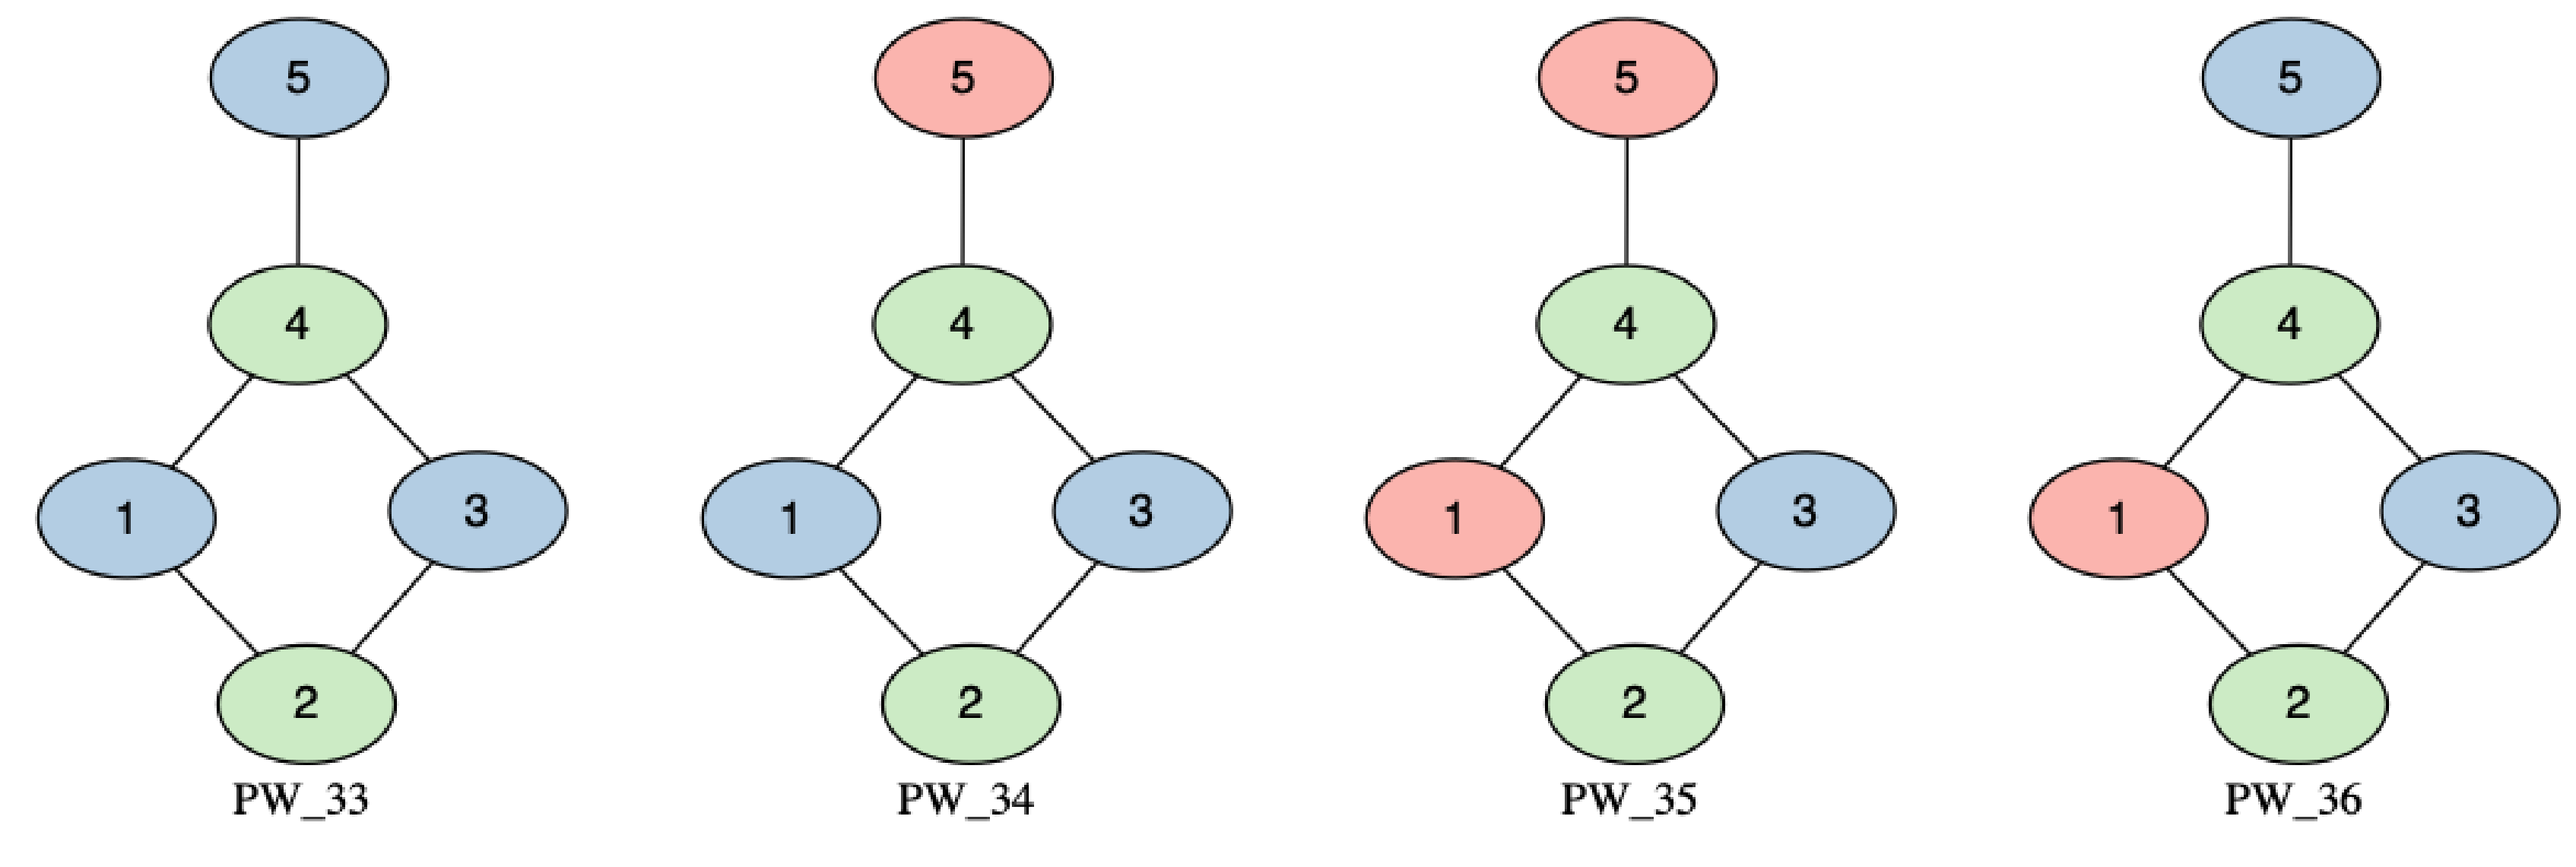

In [24]:
display_viz(vizs, no_of_columns=4)

In [25]:
# Uncomment to store the vizs (storing just the first 6 here, but you can modify to save all):
# for pw_id in range(1, 7):
#     for f in ['png', 'pdf', 'svg', 'dot']:
#         draw(vizs[pw_id], format=f, filename='3col_pw{}.{}'.format(pw_id, f), show='none')

## Grouping PWs

### Now that we have all these PWs, we want to know if we can group them.

One way to group them might be by the number of unique colors the coloring in the PW uses.

Simple SQL Type Query to check number of colors used by each solution

In [26]:
num_colors = pw_rel_dfs['col_2'].groupby(by=['pw']).nunique()['color']
num_colors

pw
1     3
2     3
3     3
4     2
5     3
6     3
7     2
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    2
16    3
17    3
18    3
19    3
20    3
21    2
22    3
23    3
24    3
25    3
26    2
27    3
28    3
29    3
30    3
31    3
32    3
33    2
34    3
35    3
36    3
Name: color, dtype: int64

Grouping the PWs by the number of colors they use

This gives us two groups, one that uses 2 colors and another that uses 3 colors

In [27]:
num_colors.groupby(num_colors.get_values()).groups

{2: Int64Index([4, 7, 15, 21, 26, 33], dtype='int64', name='pw'),
 3: Int64Index([ 1,  2,  3,  5,  6,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
             22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36],
            dtype='int64', name='pw')}

Alternate way to do the same

In [28]:
group_by_num_colors = pd.DataFrame(num_colors).groupby(['color']).groups
group_by_num_colors

{2: Int64Index([4, 7, 15, 21, 26, 33], dtype='int64', name='pw'),
 3: Int64Index([ 1,  2,  3,  5,  6,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
             22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36],
            dtype='int64', name='pw')}

##### GROUP 1 with 2 colors

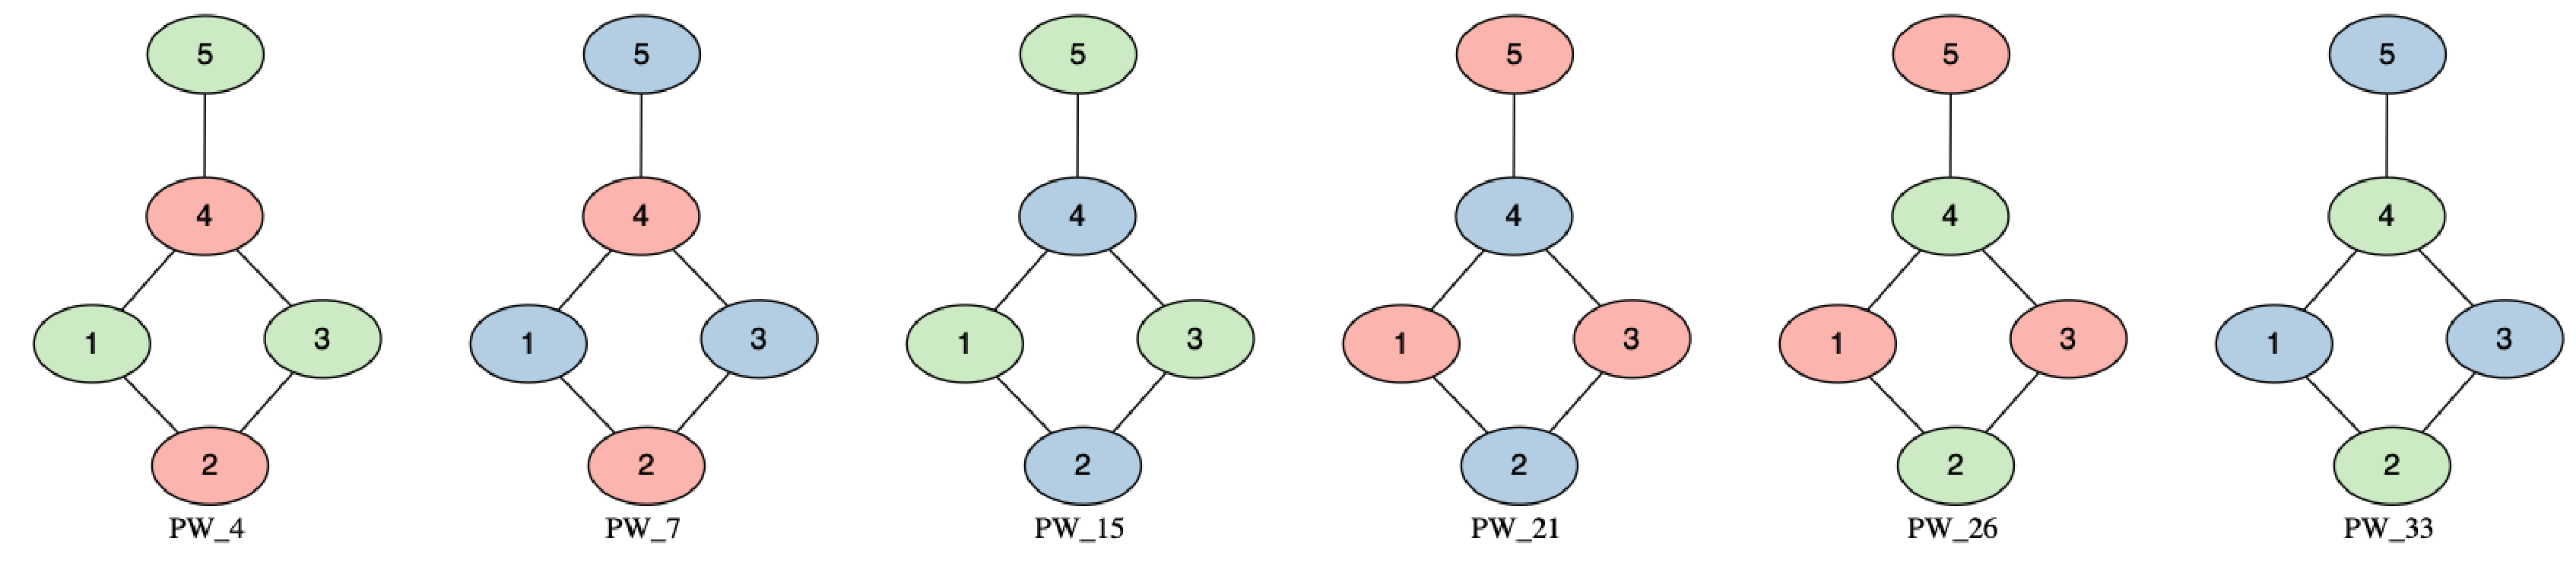

In [29]:
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in list(group_by_num_colors[2])}, no_of_columns=6)

All colorings using only 2 colors. NB: all 6 belong to the same equivalence class modulo renaming of colors.

##### GROUP 2 with 3 colors

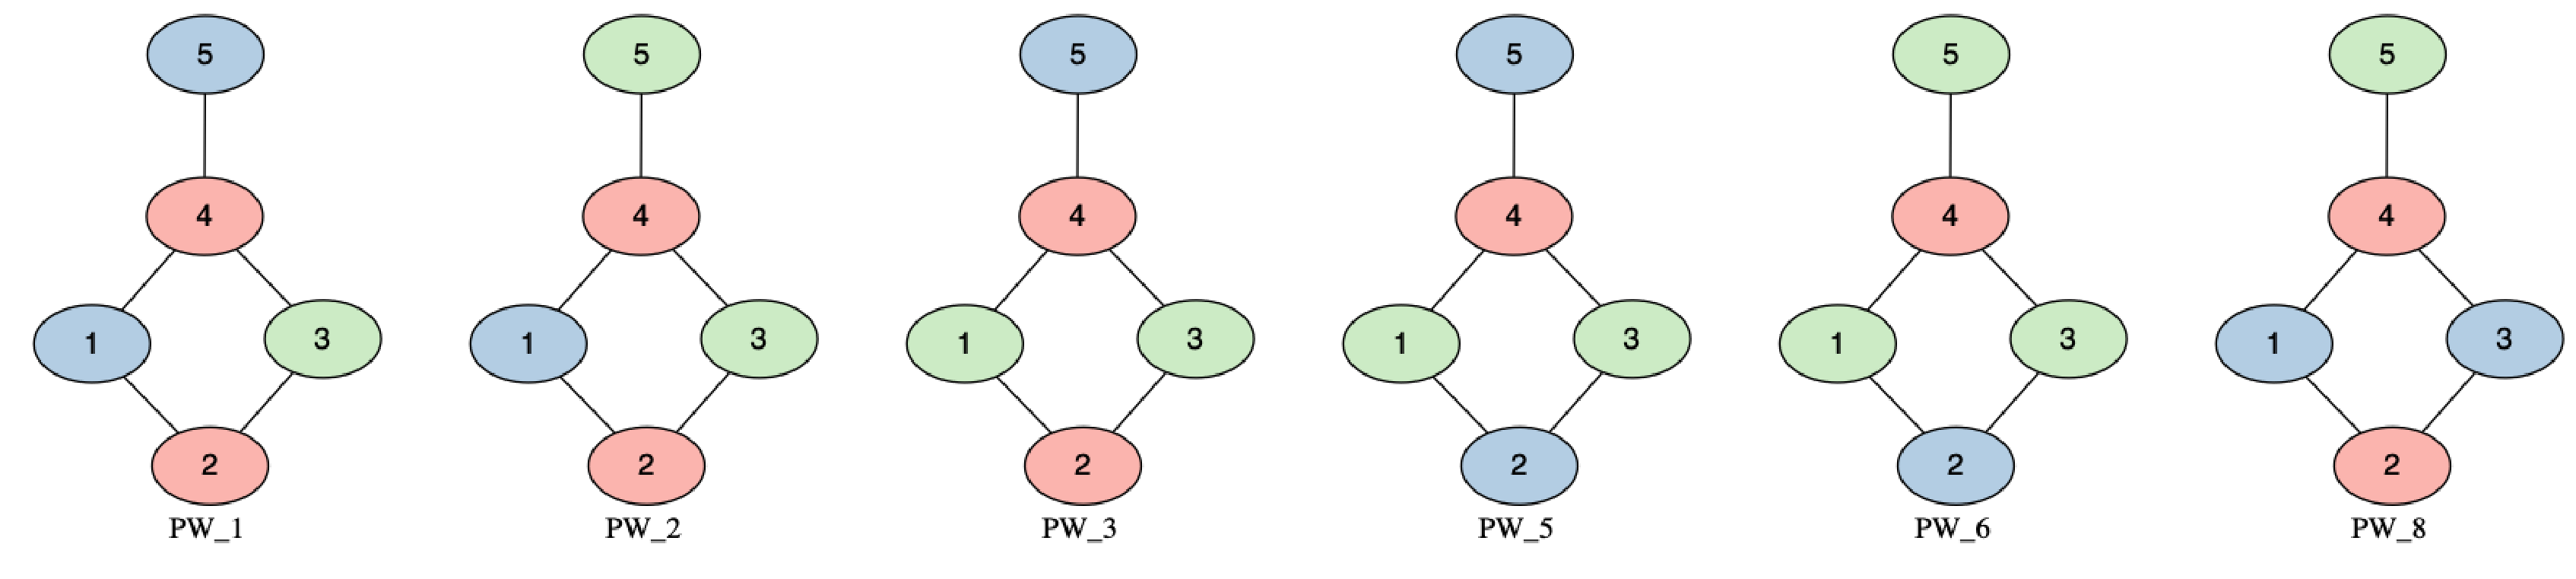

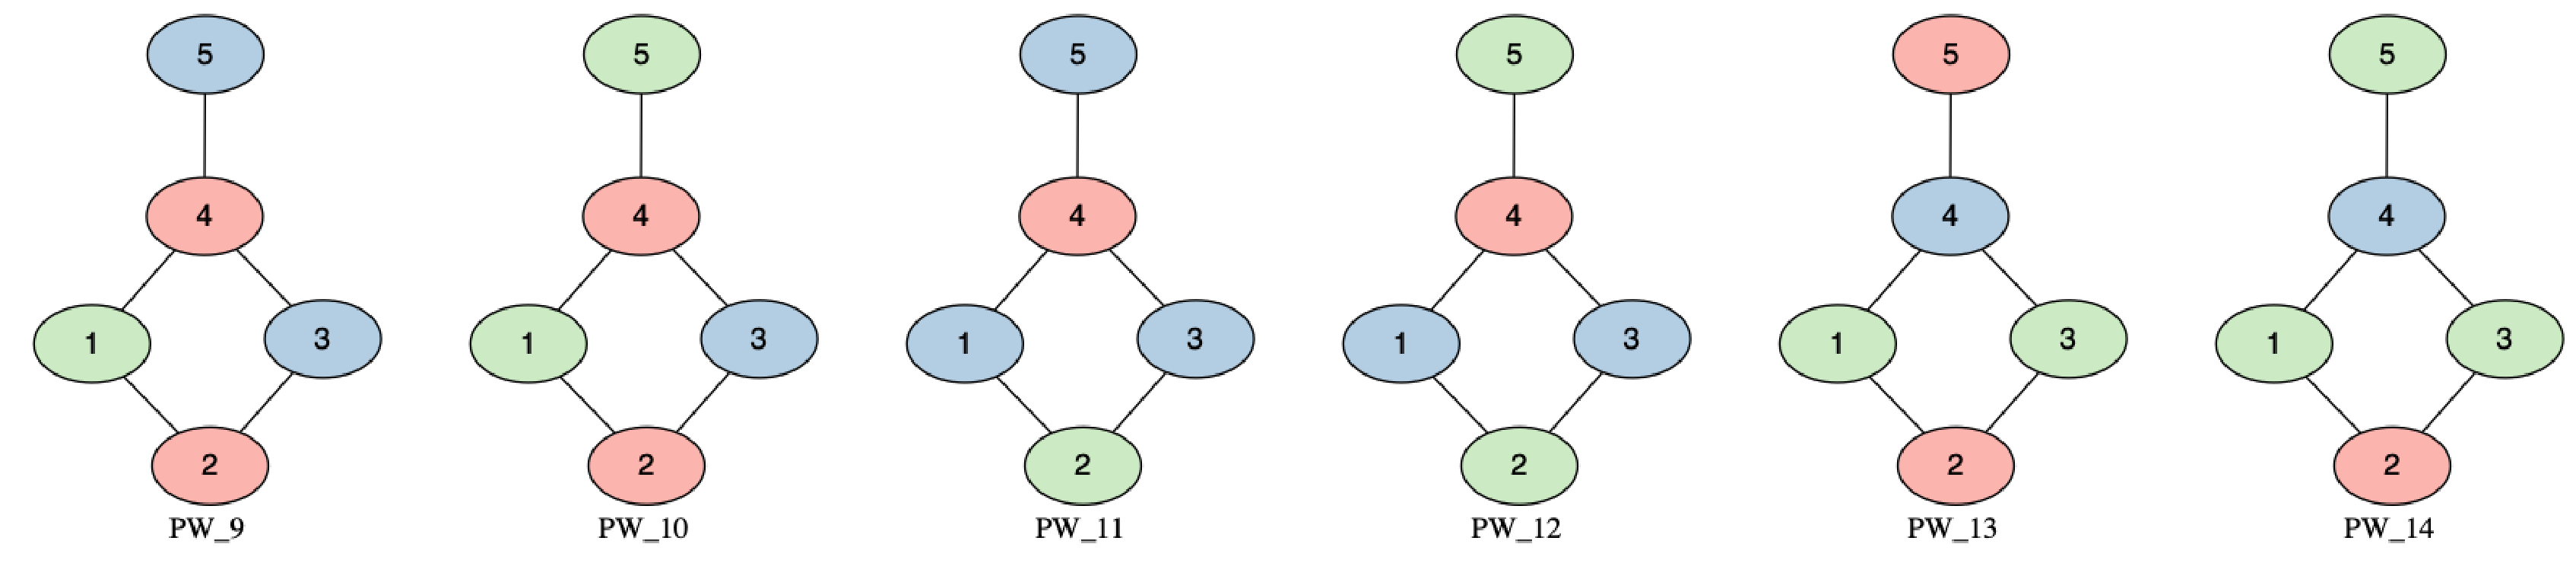

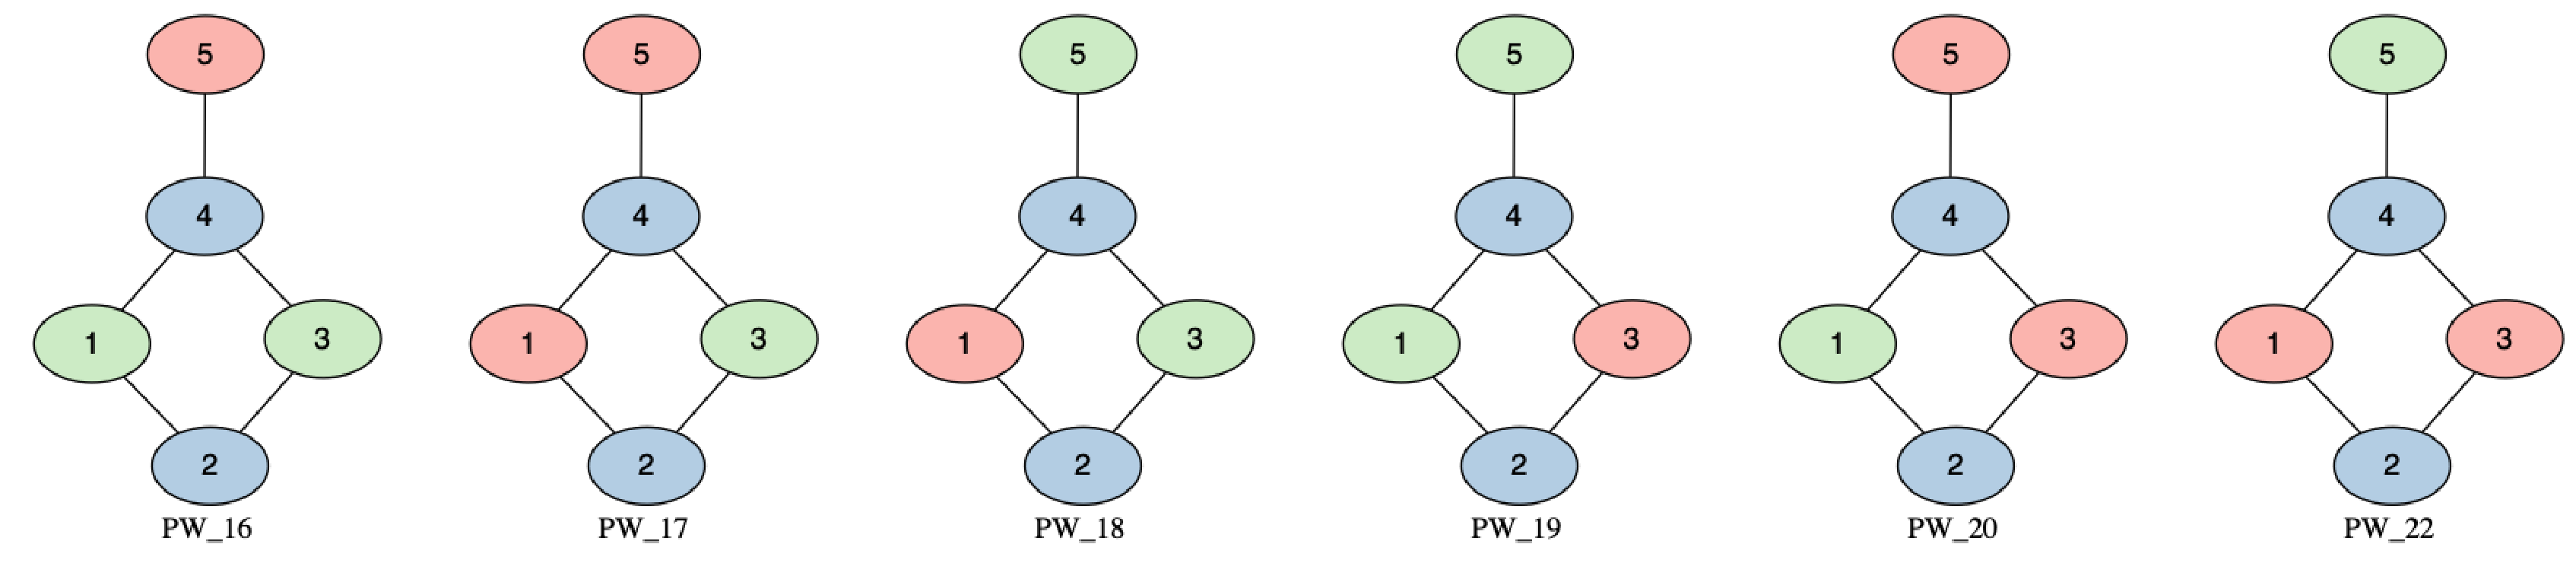

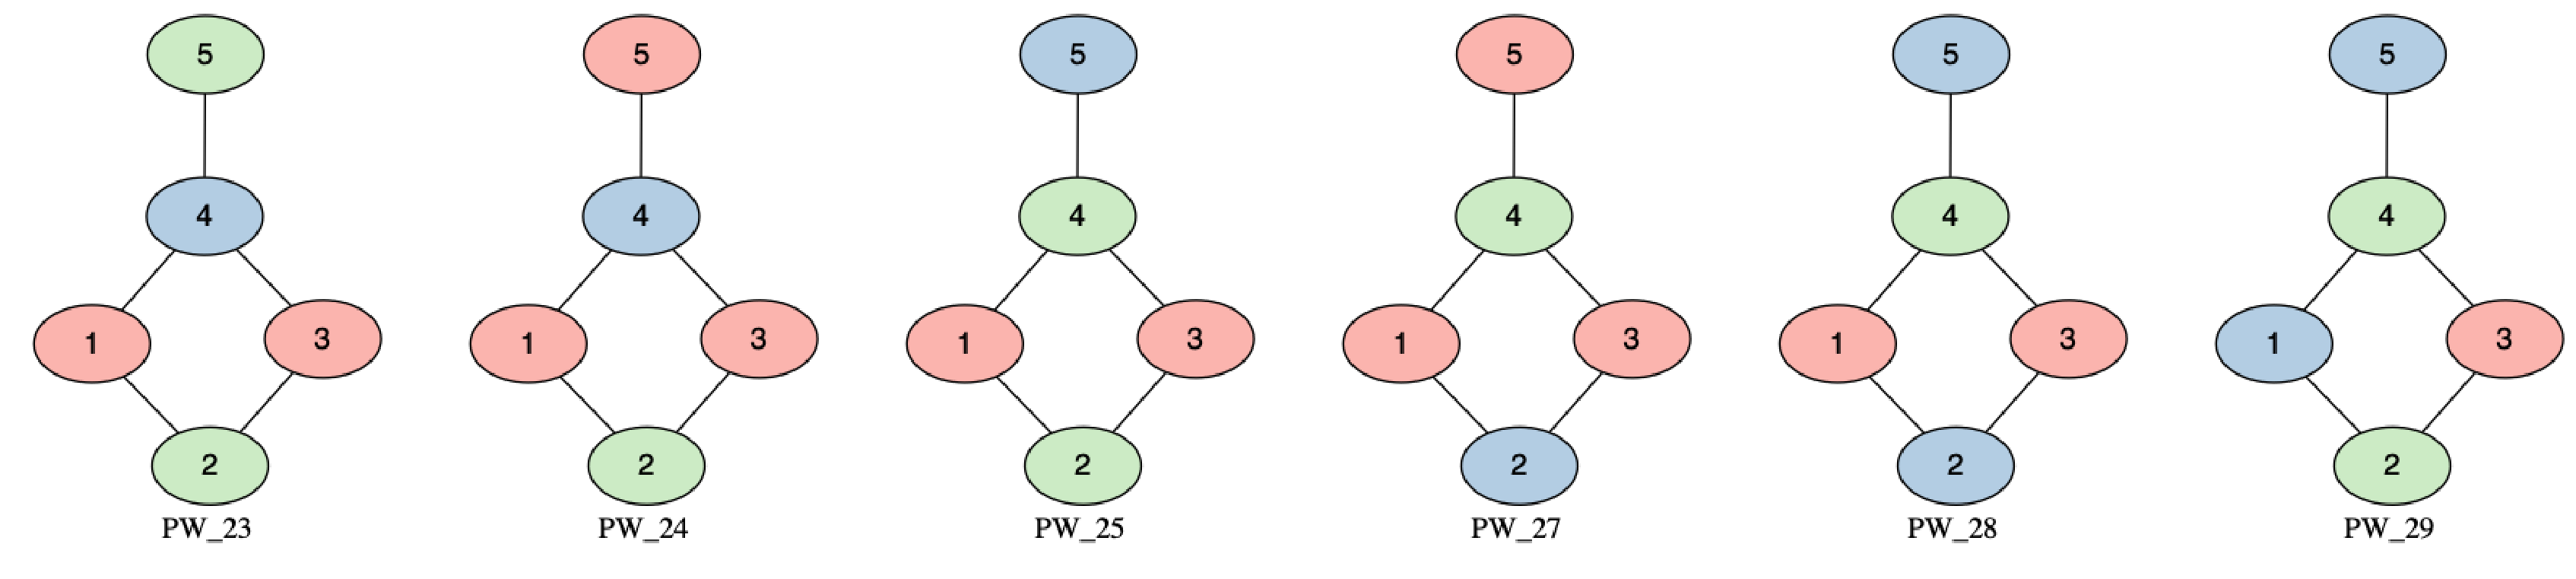

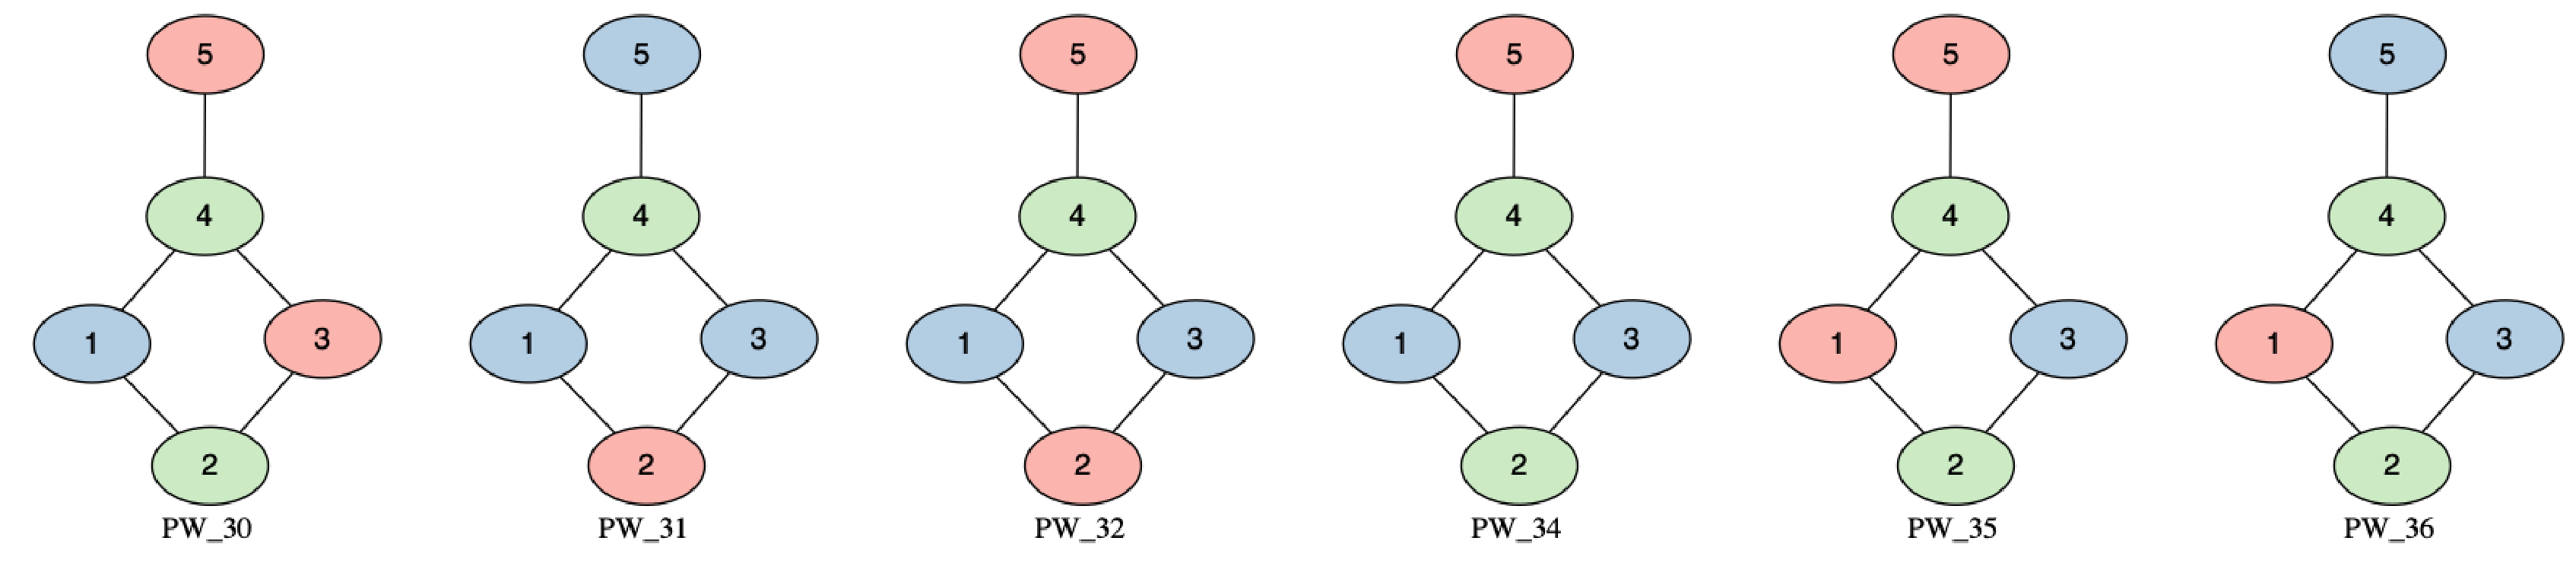

In [30]:
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in list(group_by_num_colors[3])}, no_of_columns=6)

##### However things here are more interesting since as we can see that not all these are equivalent, and there are sub-groups within this group. For instance, PW 1 and 3 are not equivalent as we can tell by inspection. So how do we COMPARE these colorings in general to find these sub-groups?

## Comparing PWs
#### Finding the differences between two PWs, say 1 and 4.
They look like this

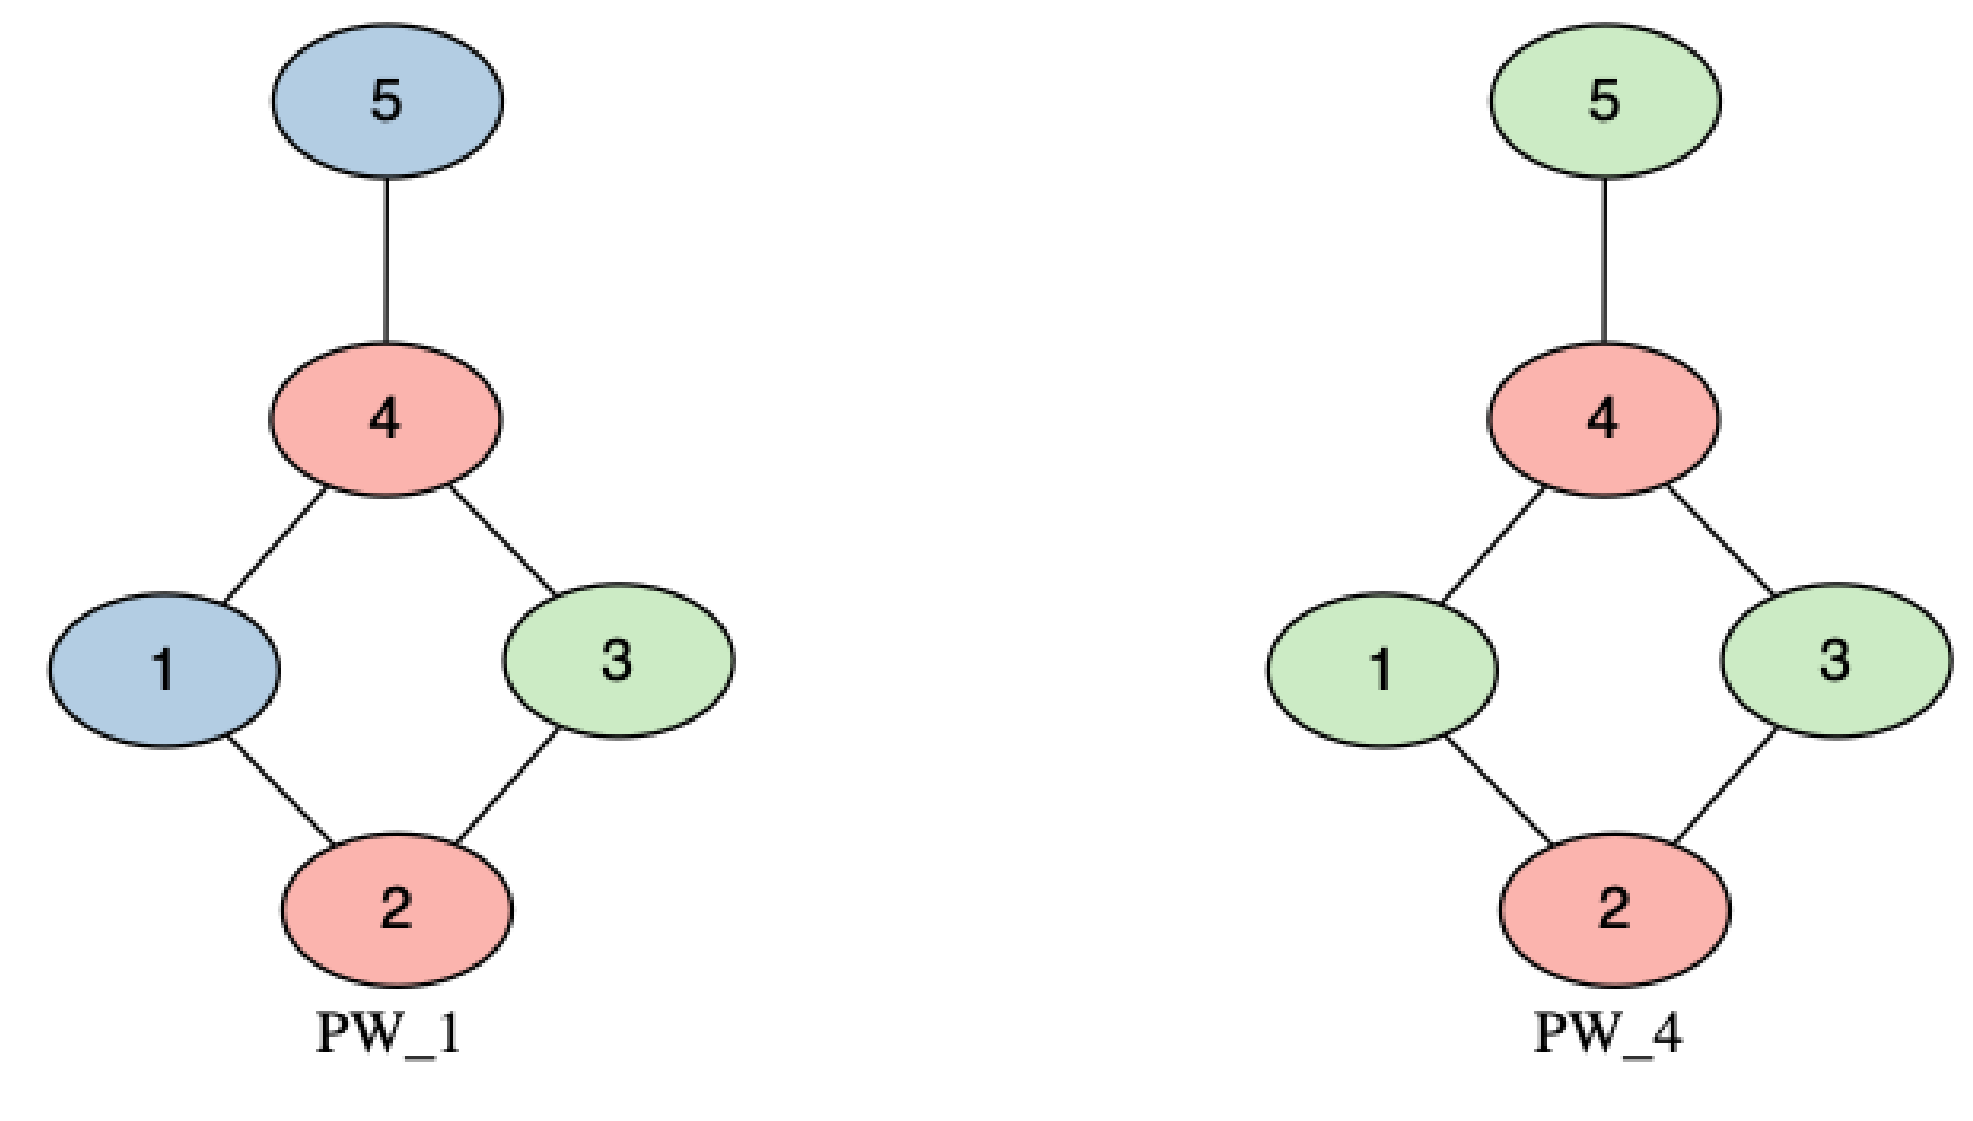

In [31]:
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in [1,4]}, no_of_columns=2, figsize=(40,20))

This is how we can formally query and find the difference between the two PWs based on their coloring

In [32]:
PWEQuery.difference_both_ways(dfs=pw_rel_dfs, do_print=True, pw_id_1=1, pw_id_2=4, rl_name='col_2')

Following tuples are in one of PW 1 or 4, but not both, for relation col_2 and features nodeID, color

  nodeID  color
0      1   blue
1      5   blue
2      1  green
3      5  green


,nodeID,color
0,1,blue
1,5,blue
2,1,green
3,5,green


## Trying to find equivalent solutions

#### So, from above, the number of differences might seem like a good estimate of how different the solutions are So, let's try that. To be able to find the groups, we create a distance matrix with the number of differences in the colorings of two PWs as the distance between the two PWs.

In [33]:
dist_matrix = np.zeros((len(pw_objs), len(pw_objs)))
for i in range(len(pw_objs)):
    for j in range(i+1, len(pw_objs)):
        dist_matrix[i][j] = dist_matrix[j][i] = len(PWEQuery.difference_both_ways(dfs=pw_rel_dfs, do_print=False, pw_id_1=i+1, pw_id_2=j+1, rl_name='col_2'))
dist_matrix

array([[ 0.,  2.,  2., ...,  8., 10.,  8.],
       [ 2.,  0.,  4., ...,  8., 10., 10.],
       [ 2.,  4.,  0., ..., 10., 10.,  8.],
       ...,
       [ 8.,  8., 10., ...,  0.,  2.,  4.],
       [10., 10., 10., ...,  2.,  0.,  2.],
       [ 8., 10.,  8., ...,  4.,  2.,  0.]])

Now let's try clustering them using the cluster-map visualization we defined at the beginning

/Users/sahil1105/PW-explorer/.env/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


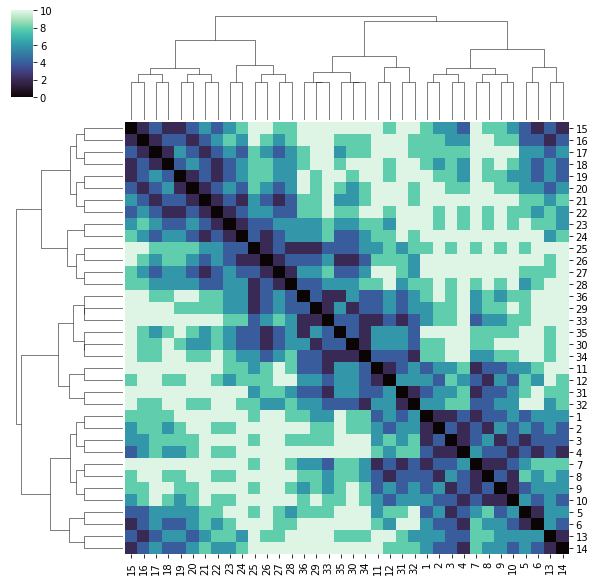

In [34]:
_ = cluster_map_viz(dist_matrix)

Trying the built-in dendrogram visualizations to get alternate dendrograms (using different build metrics internally)

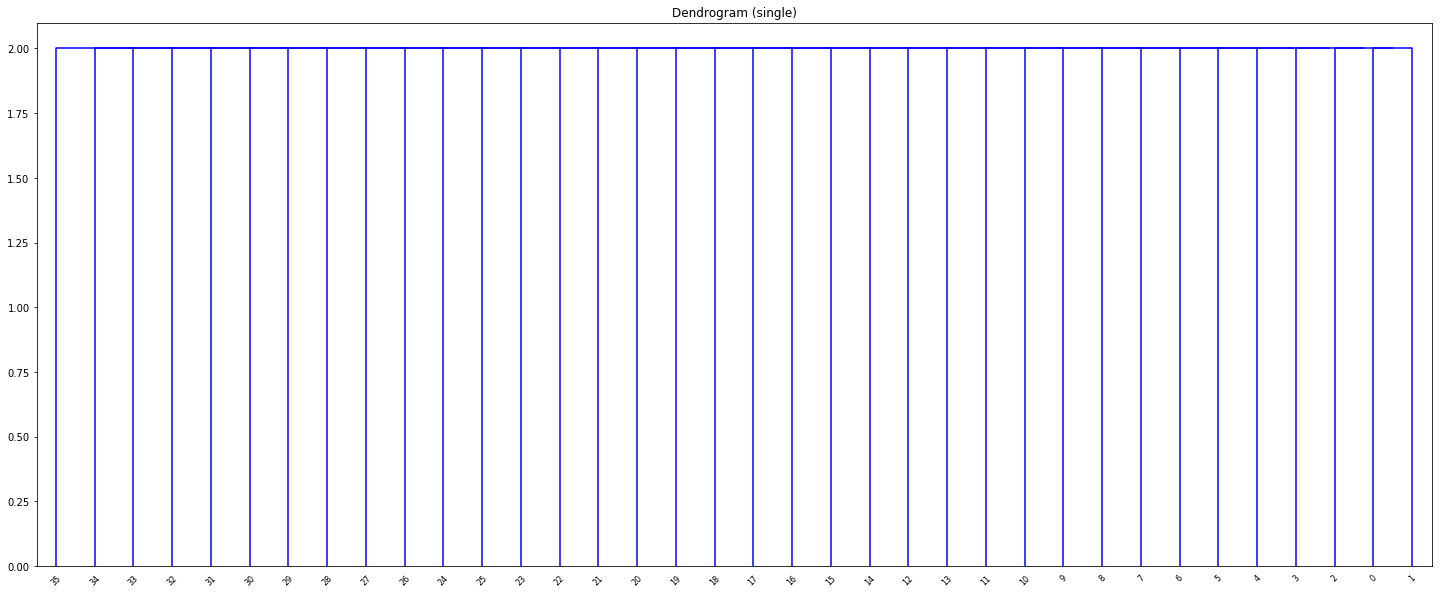

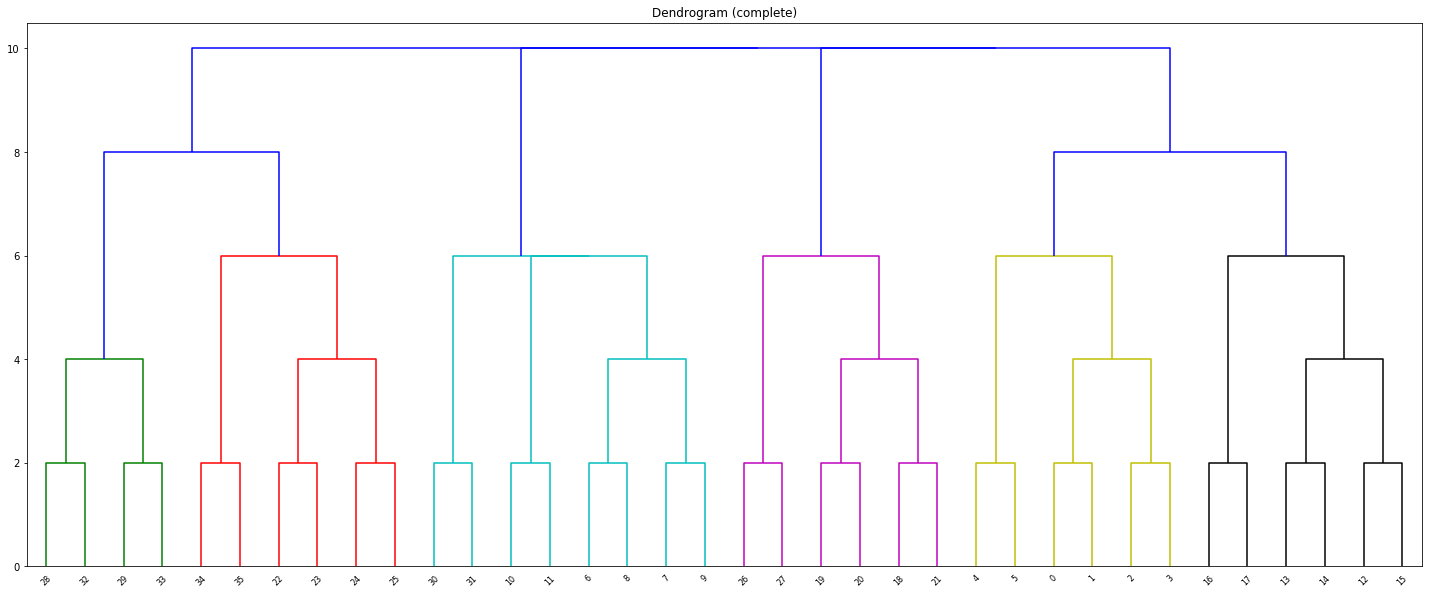

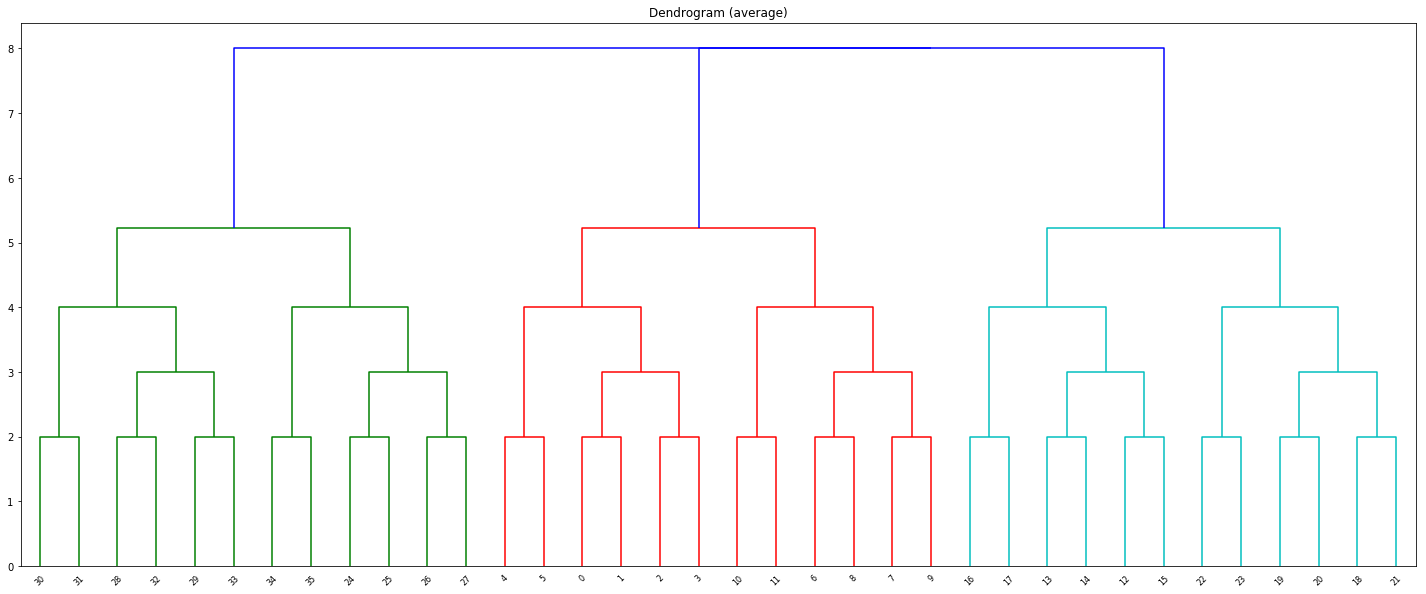

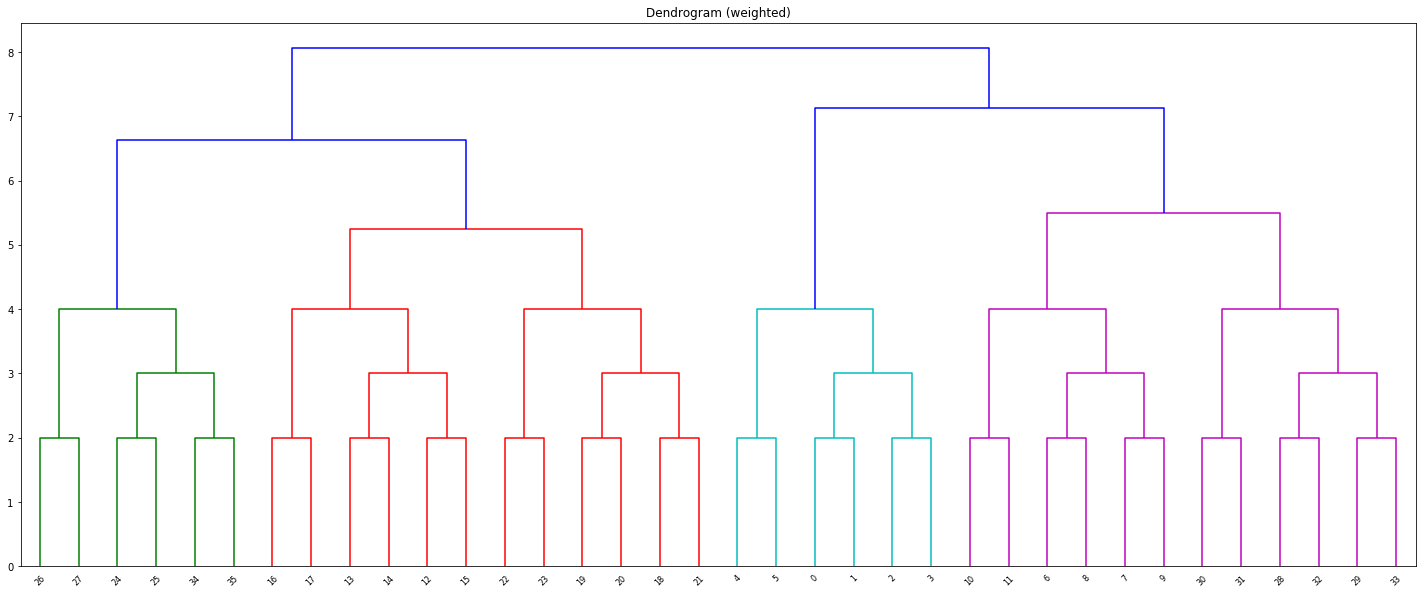

In [35]:
_ = PWEVisualization.linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

##### DOESN'T REALLY WORK. We can't see any distinct clusters. For example, we know that PWs 33, 26, 21, 15, 4, 7 are very similar (all use only 2 colors) and must be in the same cluster. But that's not reflected here.

###### As we know, the one good way of clustering these PWs is by the number of colors they use. So let's start from that.

In [36]:
dist_matrix = np.zeros((len(pw_objs), len(pw_objs)))
for i in range(len(pw_objs)):
    for j in range(i+1, len(pw_objs)):
        dist_matrix[i][j] = dist_matrix[j][i] = abs(num_colors[i+1] - num_colors[j+1]) + 1
dist_matrix

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

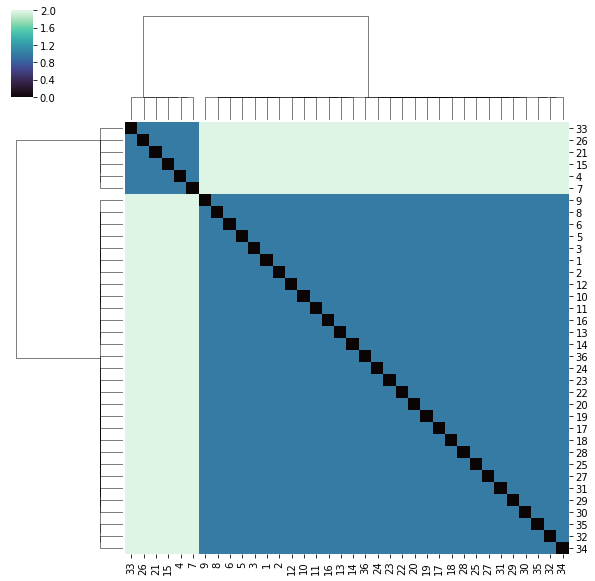

In [37]:
_ = cluster_map_viz(dist_matrix)

##### THIS OF COURSE WORKS, AS CAN BE VERIFIED HERE USING THE BUILT-IN VISUALIZATION. 
#### We get the two distinct clusters from before. One cluster that has PWs that use 2 colors (let's call this cluster C2) and another that uses 3 colors (let's call this cluster C3).

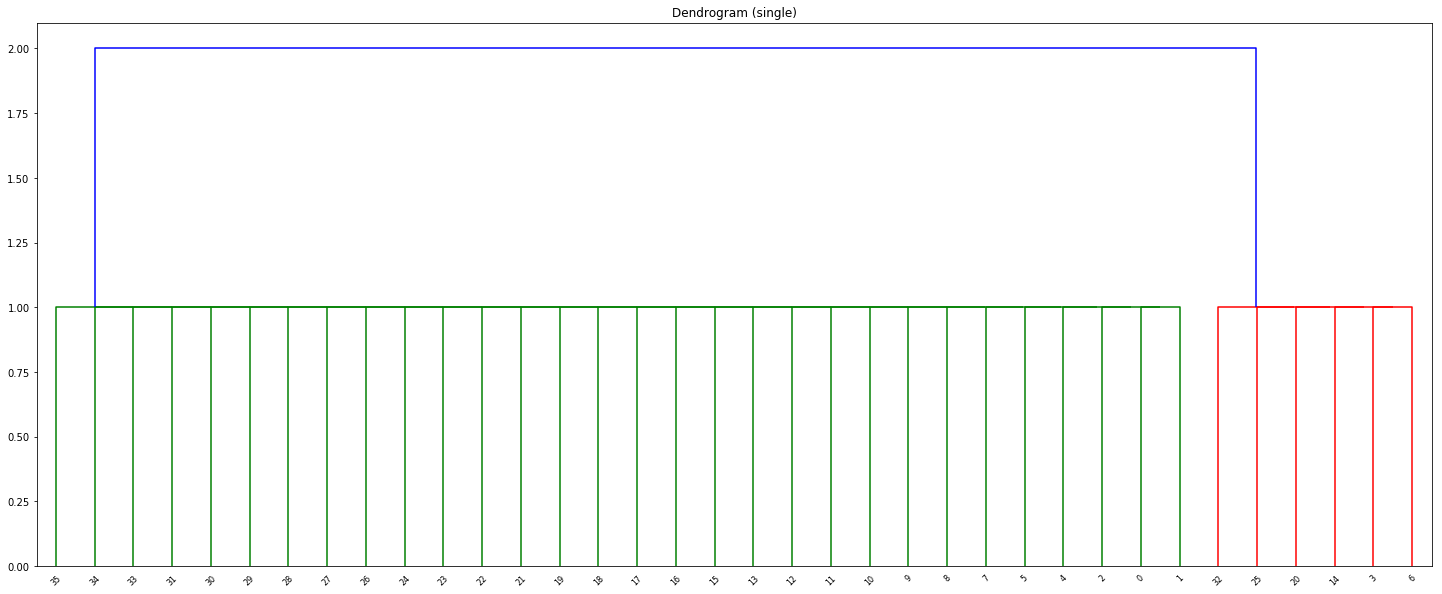

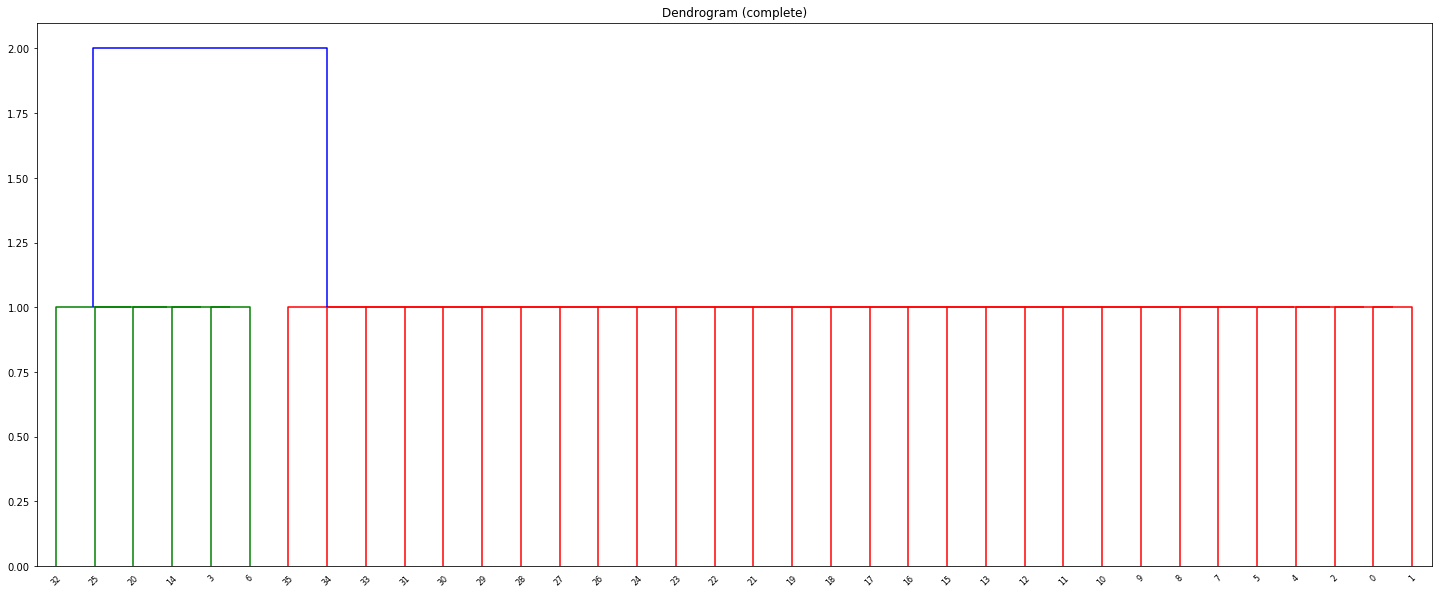

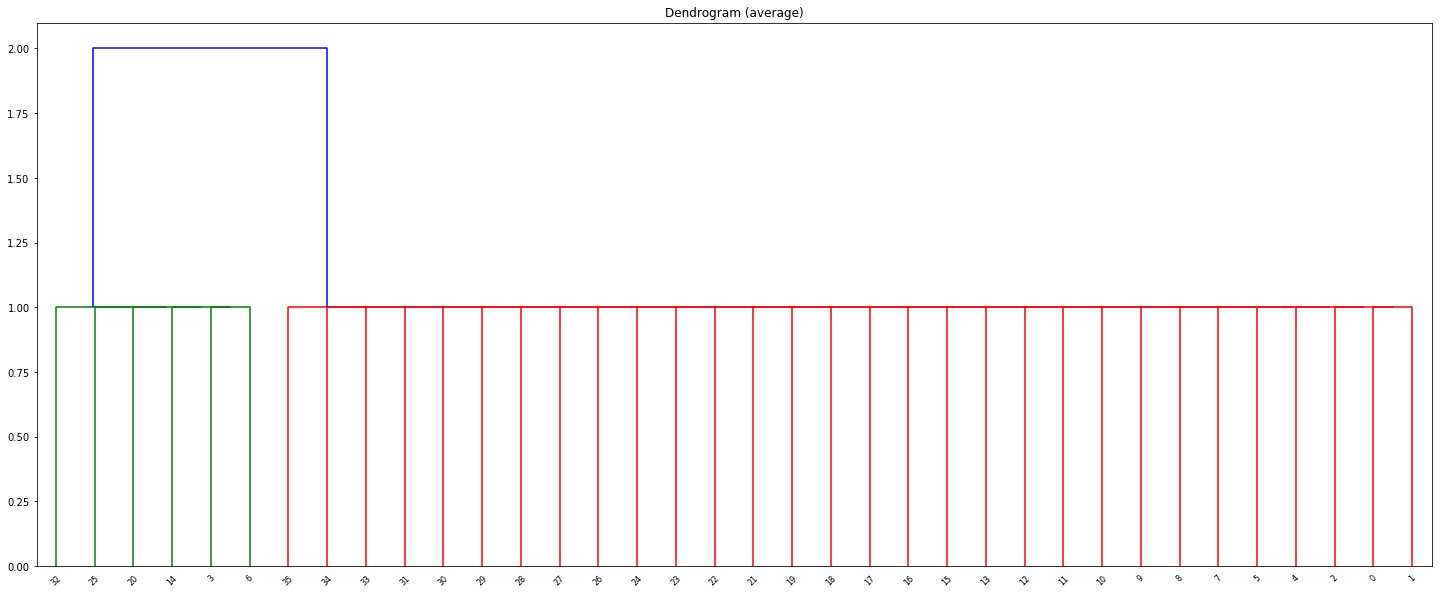

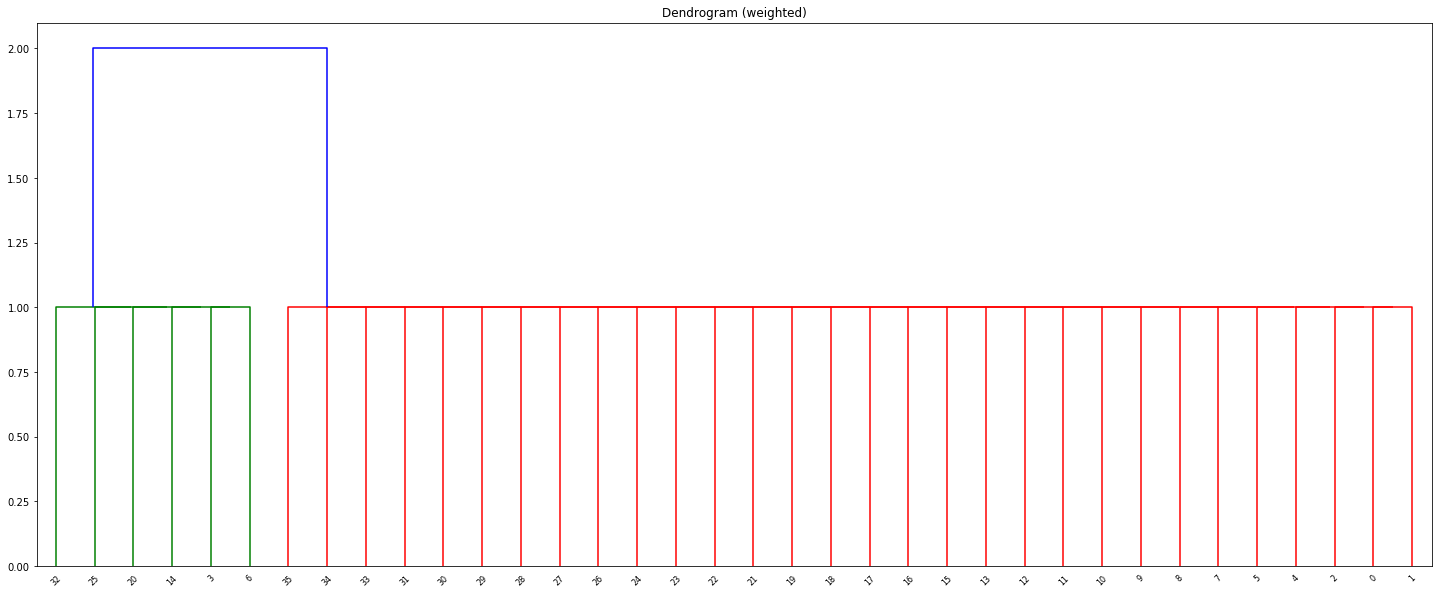

In [38]:
_ = PWEVisualization.linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

##### However, we want to go further. We know from inspection that C3 has sub-clusters based on the different coloring-isomorphisms. Our first attempt was ignorant to the fact that the colorings 'brbrg' and 'gbgbr' are actually equivalent. So to find the subclusters, we must compare these patterns rather than the color assignments themselves.

In [39]:
def get_pattern(sequence):
    """
    Get the underlying pattern in the form of a list of integers (and the number of unique colors used)
    """
    pattern = []
    pattern_dict = {}
    count_unique = 0

    for element in sequence:

        if element in pattern_dict:
            pattern.append(pattern_dict[element])
        else:
            pattern.append(count_unique)
            pattern_dict[element] = count_unique
            count_unique += 1

    return pattern, count_unique

def get_colors_list(df, id_):
    """
    Get the list of colors ordered by the nodeID
    """
    idx = list(map(int, list(df[df.pw == id_].nodeID)))
    clrs = list(df[df.pw == id_].color)
    ordered_clrs = [x for _, x in sorted(zip(idx, clrs))]
    return ordered_clrs

We define a new distance function that compares the number of differences in the pattern of two colorings. We also apply a high penalty for not using the same number of colors, since we know from above that this is a helpful metric for clustering.

In [40]:
def pat_dist(col_df, pw_id_1, pw_id_2):
    s1 = get_colors_list(col_df, pw_id_1)
    s2 = get_colors_list(col_df, pw_id_2)
    pattern_s1, unique_s1 = get_pattern(s1)
    pattern_s2, unique_s2 = get_pattern(s2)
    
    return sum([pattern_s1[i] != pattern_s2[i] for i in range(len(pattern_s1))]) + 10*abs(unique_s1 - unique_s2) + 1

Like before, we create a distance matrix, this time based on the above distance matrix.

In [41]:
dist_matrix = np.zeros((len(pw_objs), len(pw_objs)))
for i in range(len(pw_objs)):
    for j in range(i+1, len(pw_objs)):
        dist_matrix[i][j] = dist_matrix[j][i] = pat_dist(pw_rel_dfs['col_2'], i+1, j+1) + 1
dist_matrix

array([[0., 3., 4., ..., 4., 2., 3.],
       [3., 0., 3., ..., 3., 3., 2.],
       [4., 3., 0., ..., 2., 4., 3.],
       ...,
       [4., 3., 2., ..., 0., 4., 3.],
       [2., 3., 4., ..., 4., 0., 3.],
       [3., 2., 3., ..., 3., 3., 0.]])

#### On clustering these, we get some very clear clusters.

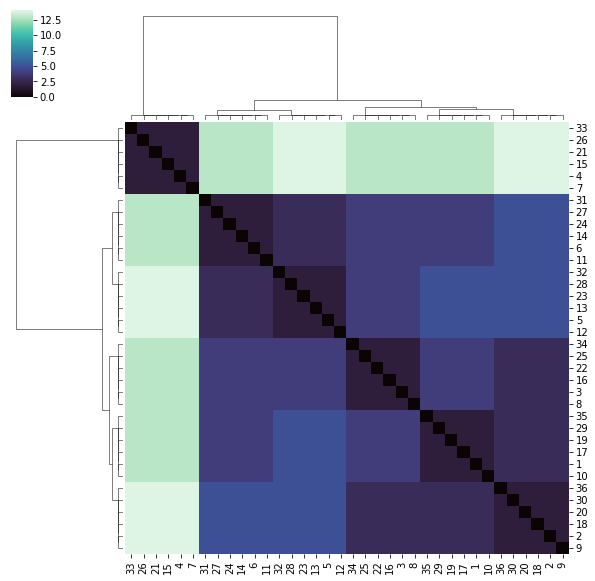

In [42]:
_ = cluster_map_viz(dist_matrix)

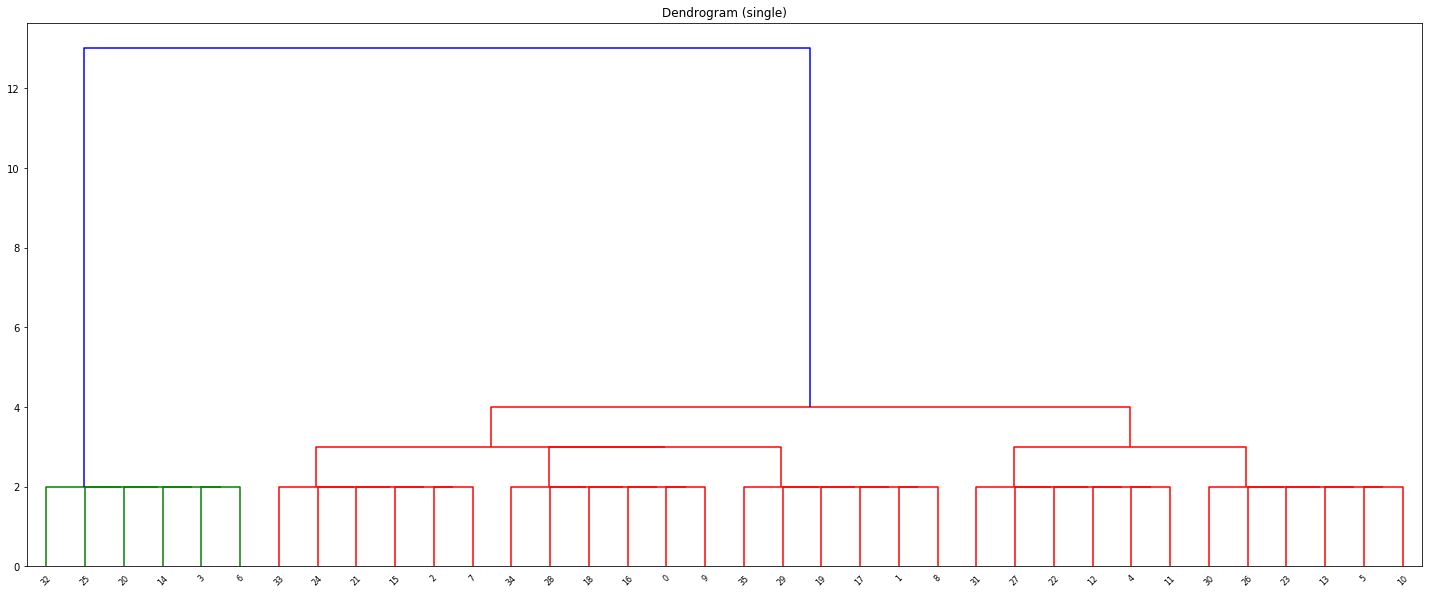

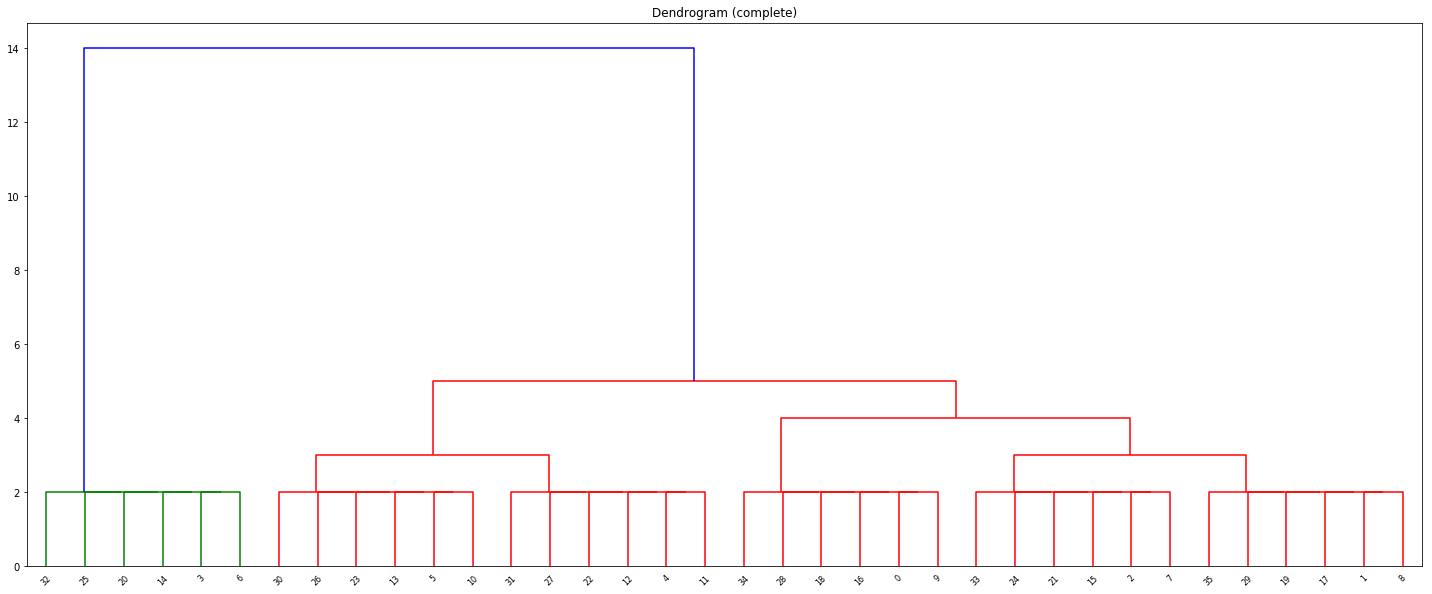

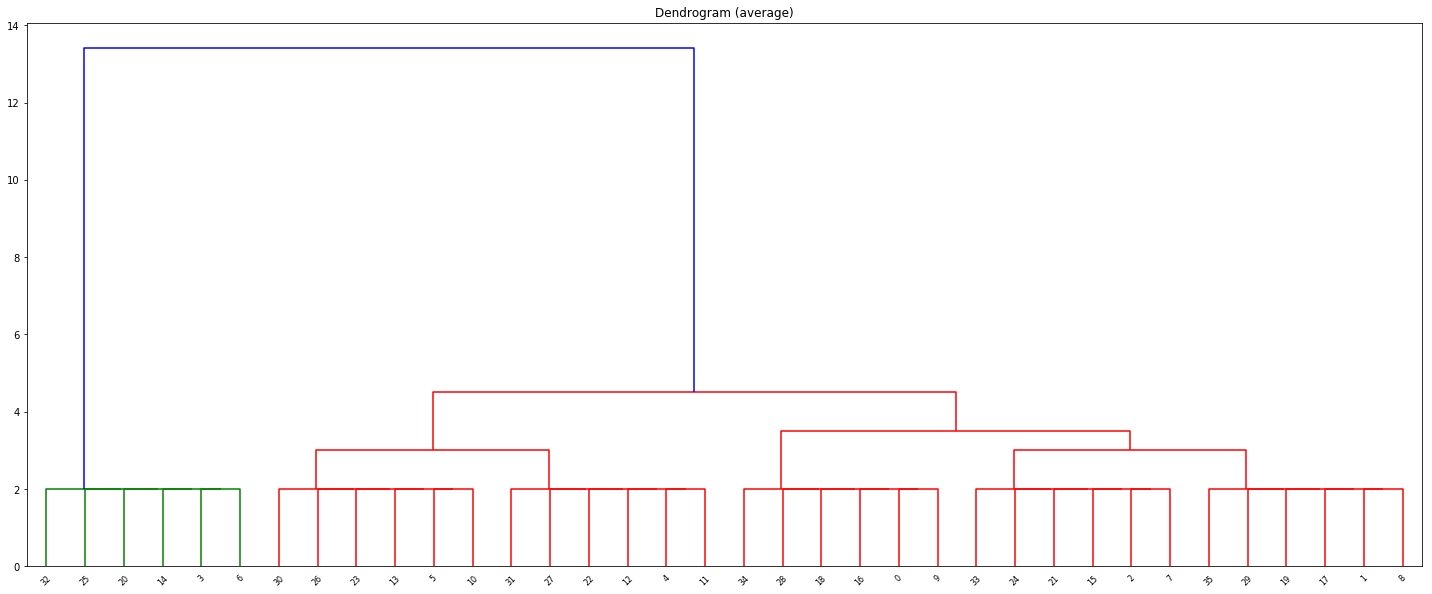

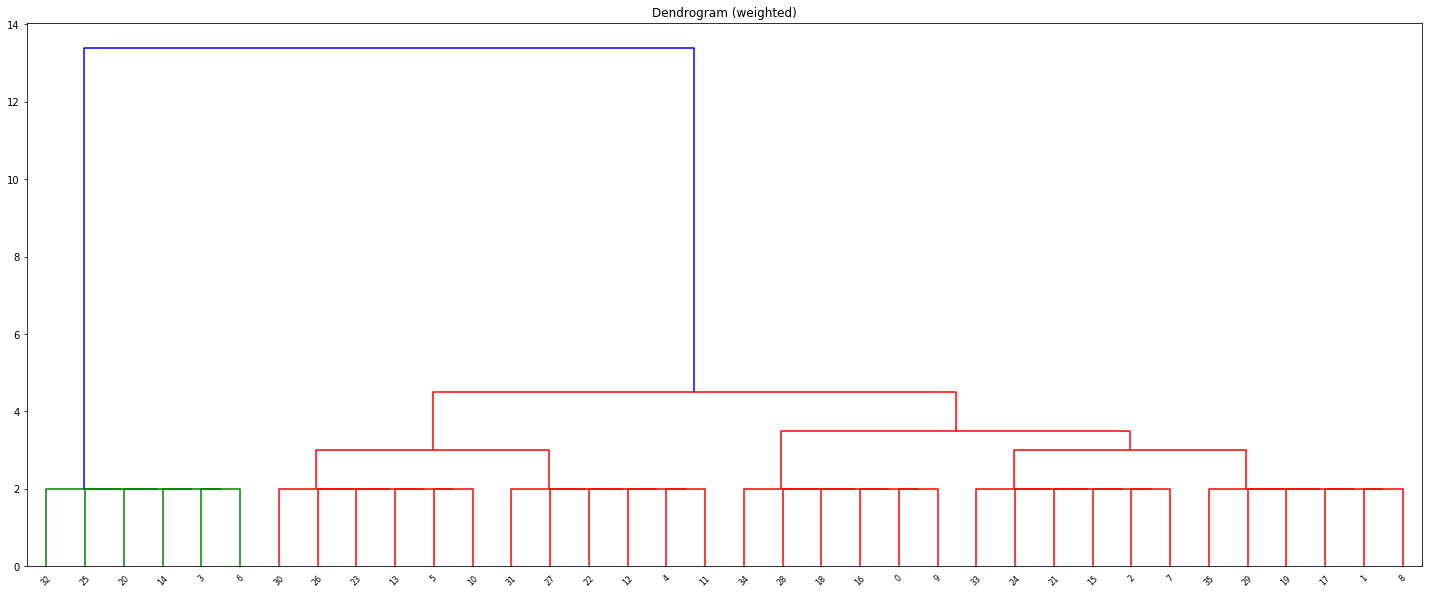

In [43]:
_ = PWEVisualization.linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

#### In all we get 6 clusters at the lowest level of granularity.

In [44]:
PATTERN_VIZ_CMAP = {'red': 'black', 'blue':'black', 'green':'black'}
PATTERN_VIZ_COLORSCHEME = 'x11'
PATTERN_VIZ_COLOR_NODE_SHAPE_MAP = {'red': 'box', 'blue': 'oval', 'green': 'octagon'}
PATTERN_VIZ_PRINT_TITLE = False
PATTERN_VIZ_FILL_TYPE = 'solid'

In [45]:
pattern_reps = []

##### Cluster 1
#### The first cluster is the set of PWs using 2 colors.

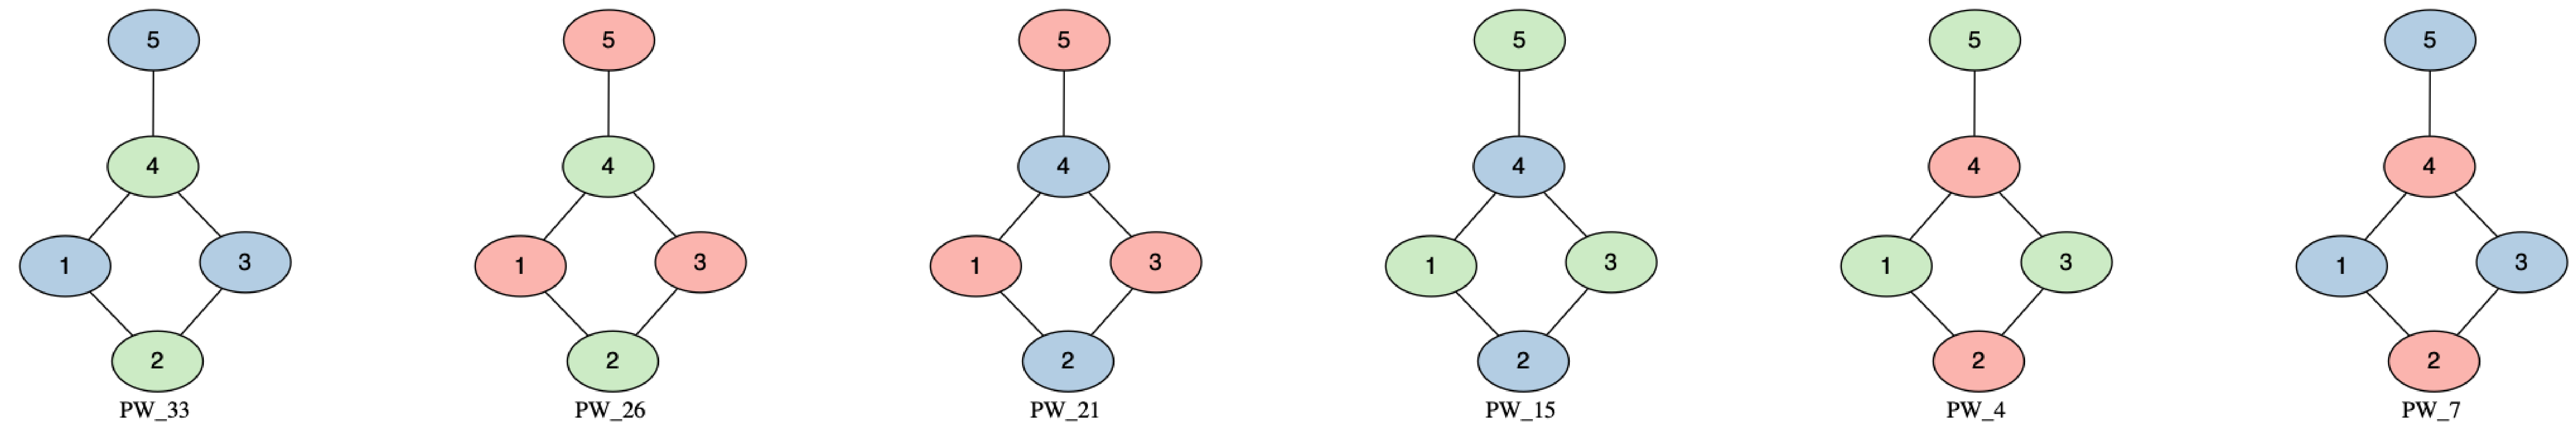

In [46]:
cl = [33, 26, 21, 15, 4, 7]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

The pattern here can be represented as below

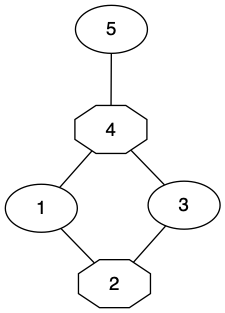

In [47]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

##### Cluster 2

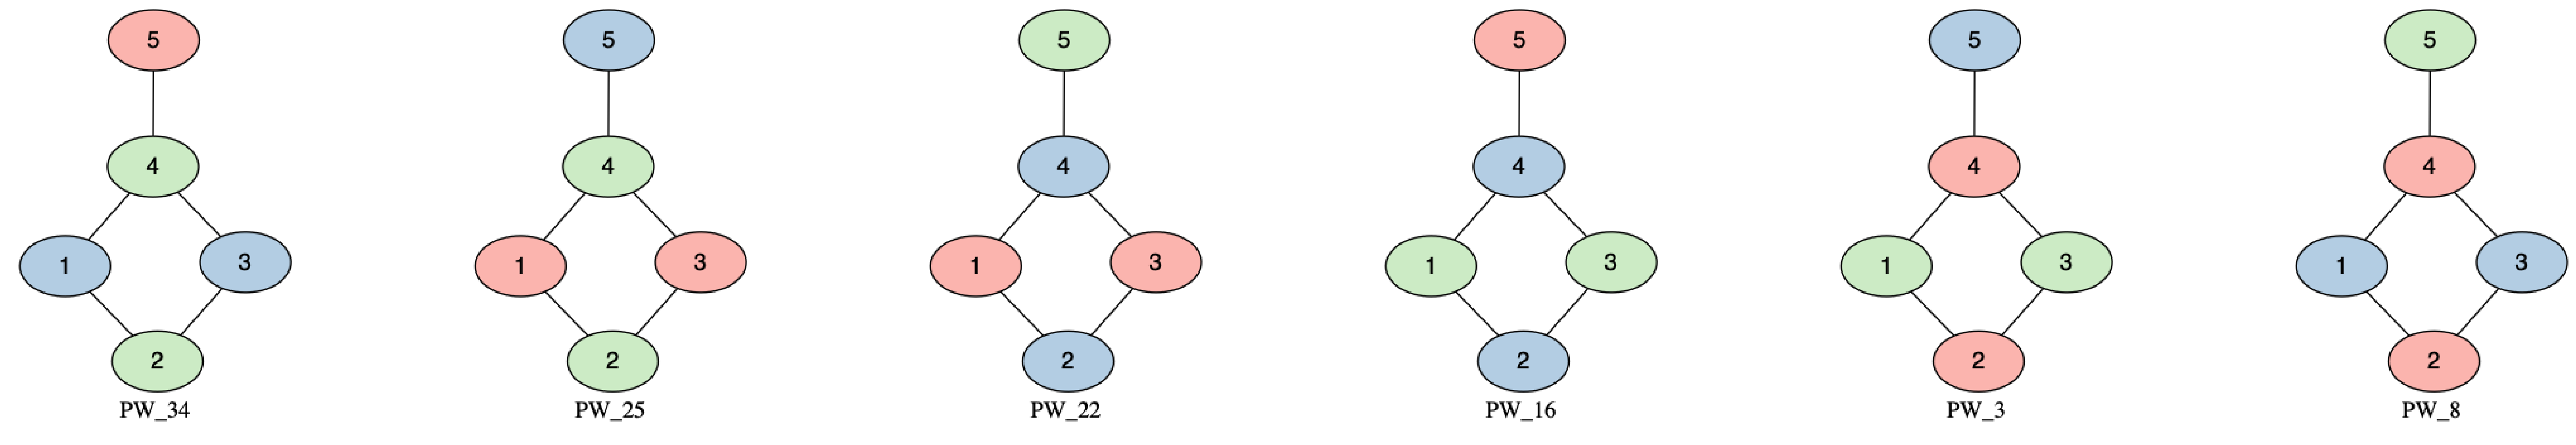

In [48]:
cl = [34, 25, 22, 16, 3, 8]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

The pattern here can be represented as below

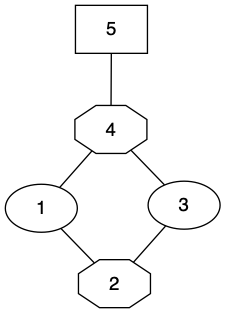

In [49]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

We further see that the next two clusters (clusters 3 and 4) are actually equivalent

##### Cluster 3

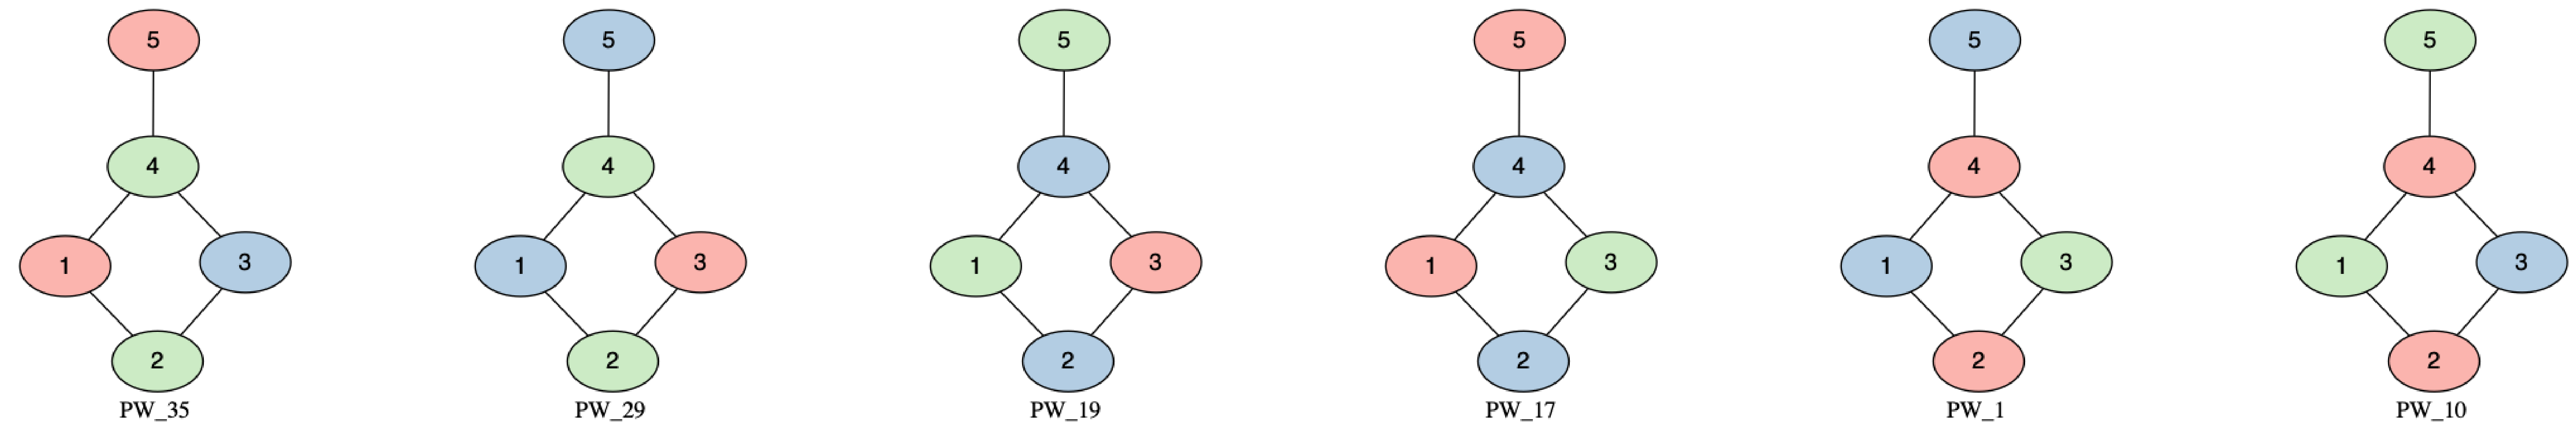

In [50]:
cl = [35, 29, 19, 17, 1, 10]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

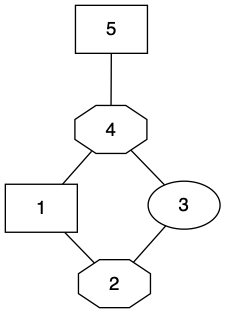

In [51]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

##### Cluster 4

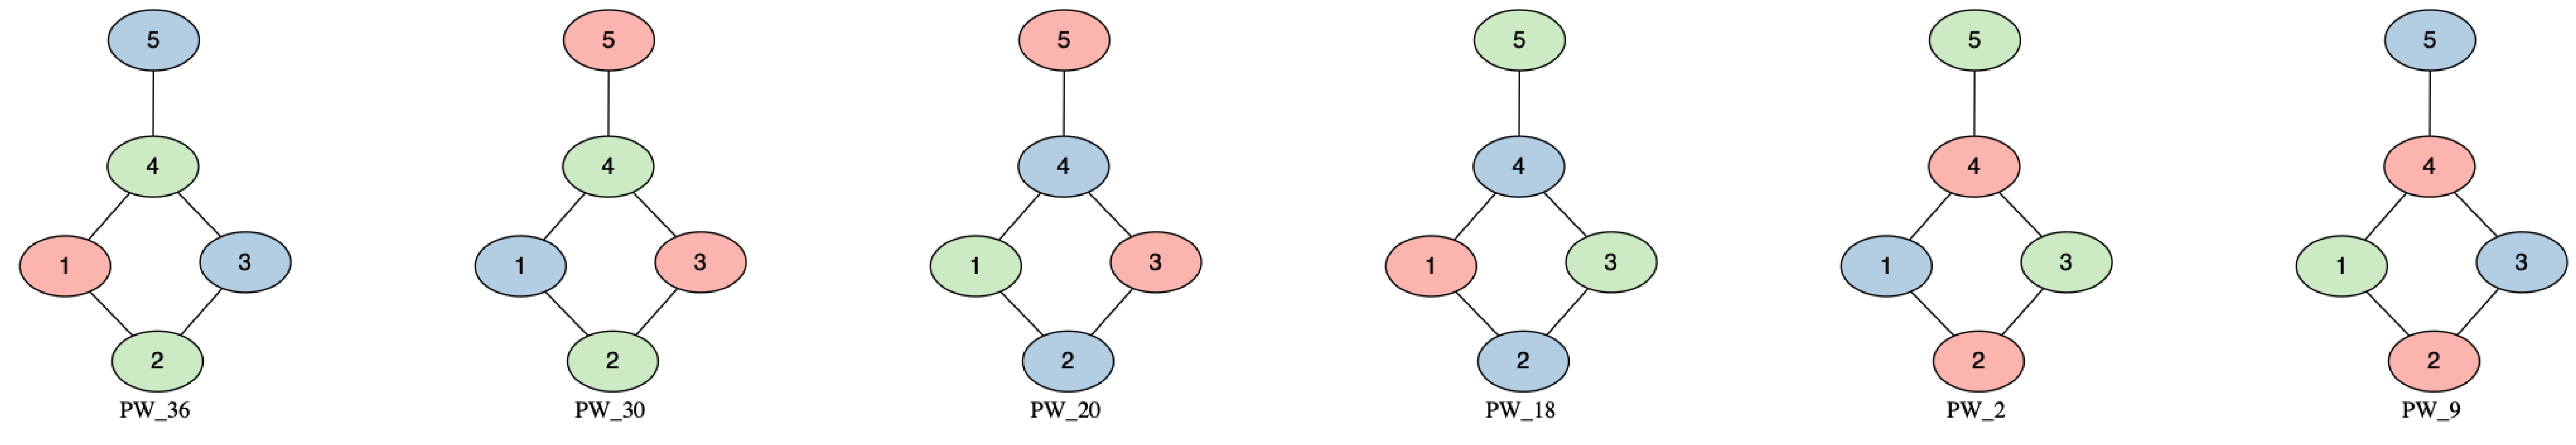

In [52]:
cl = [36, 30, 20, 18, 2, 9]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

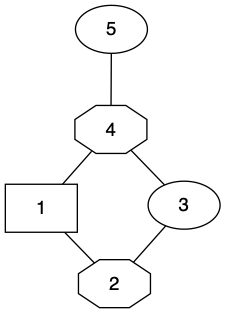

In [53]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

##### Cluster 5

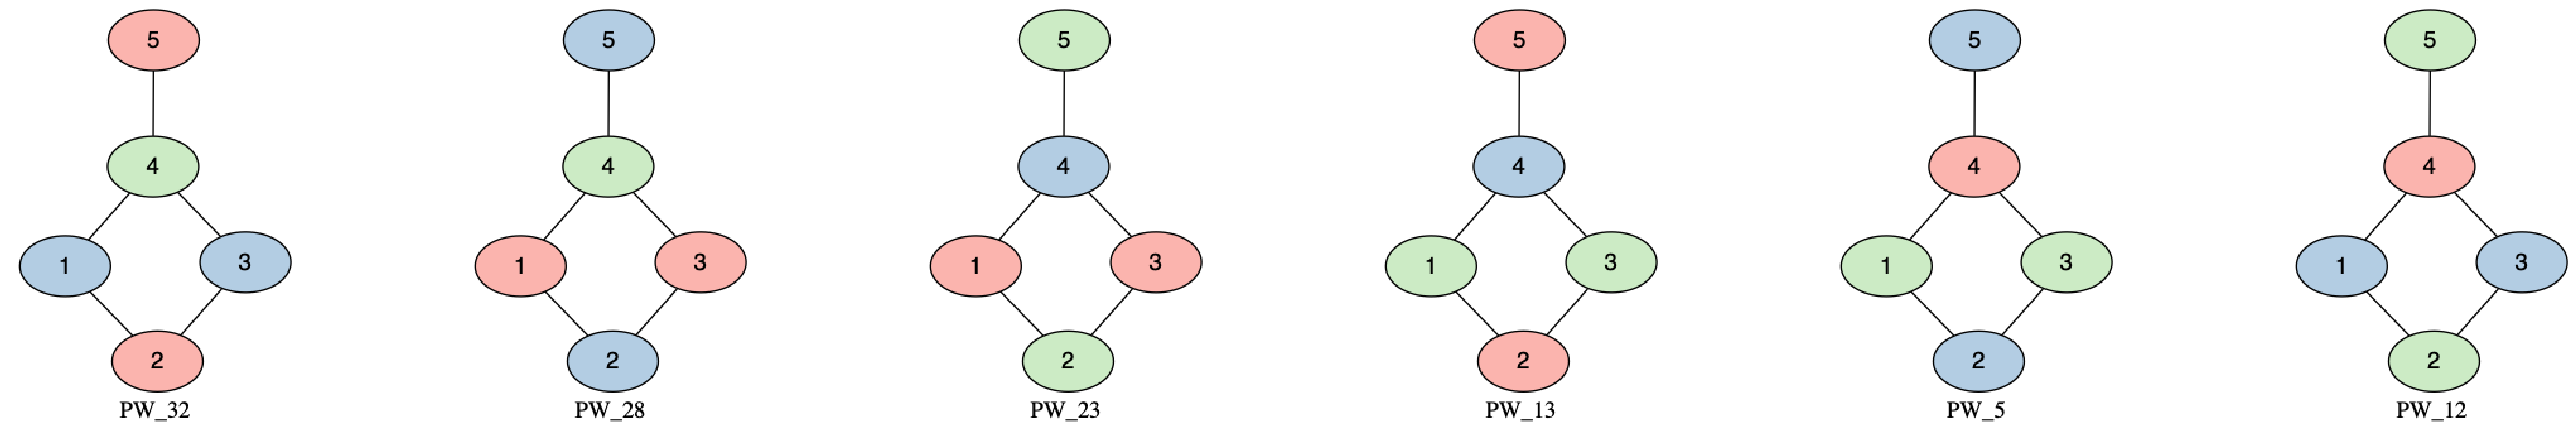

In [54]:
cl = [32, 28, 23, 13, 5, 12]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

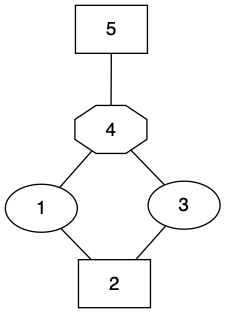

In [55]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

##### Cluster 6

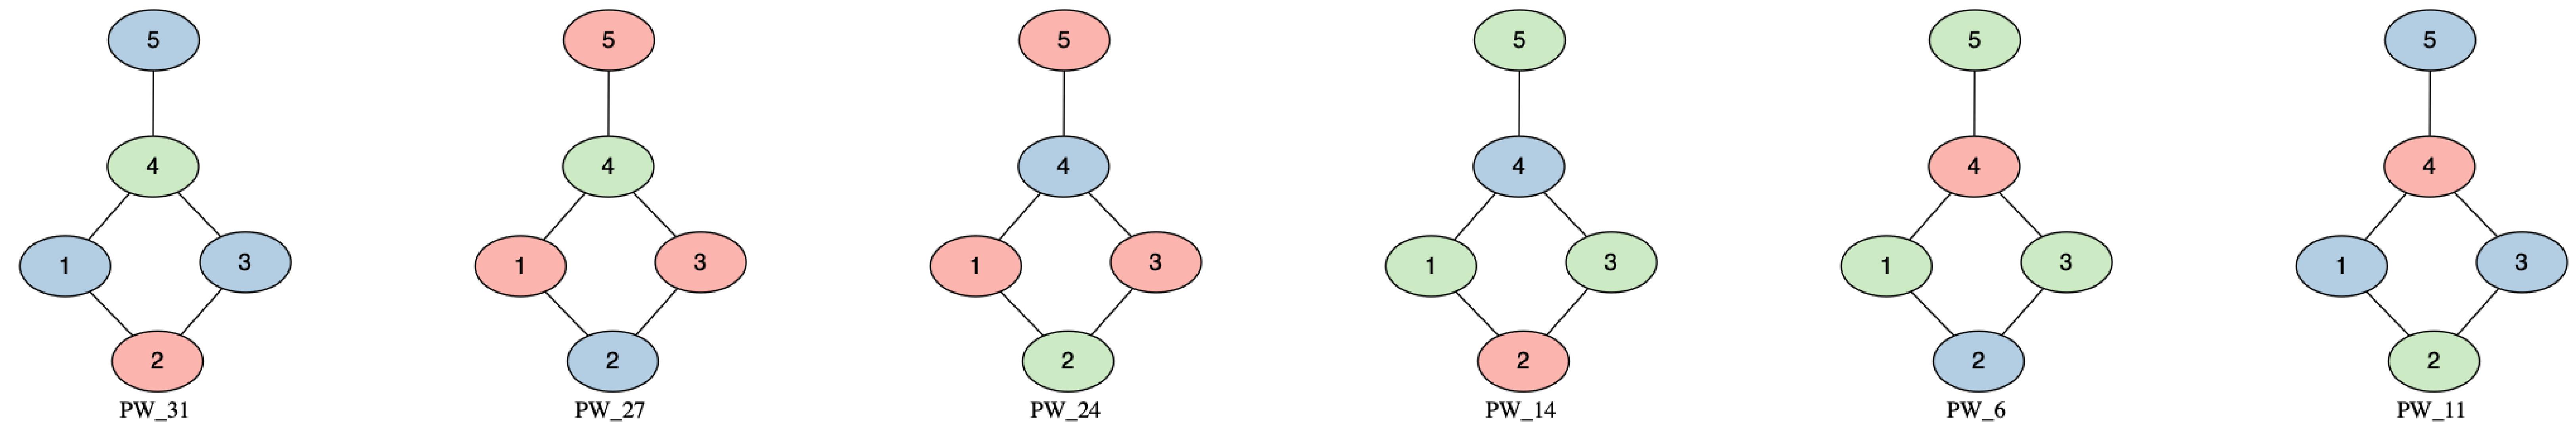

In [56]:
cl = [31, 27, 24, 14, 6, 11]
display_viz(vizs={pw_id: vizs[pw_id] for pw_id in cl}, no_of_columns=6, figsize=(120,20))

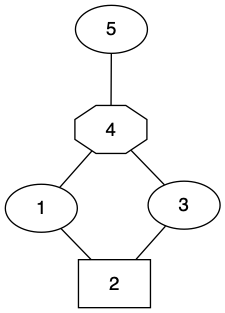

In [57]:
# Pattern of the cluster:
pattern = colorability_viz(pw_rel_dfs, cl[0], fill_type=PATTERN_VIZ_FILL_TYPE, 
                           cmap=PATTERN_VIZ_CMAP, colorscheme=PATTERN_VIZ_COLORSCHEME, 
                           color_to_node_shape_map=PATTERN_VIZ_COLOR_NODE_SHAPE_MAP, 
                           print_title=PATTERN_VIZ_PRINT_TITLE)
pattern_reps.append(pattern)
draw(pattern)

In [58]:
# Uncomment to save the visualizations
# for i in range(len(pattern_reps)):
#     for f in ['pdf', 'png', 'svg', 'dot']:
#         draw(pattern_reps[i], format=f, filename='3col_pattern{}.{}'.format(i+1, f), show='none')

#### RECAP: So in all, these are the 6 detected patterns

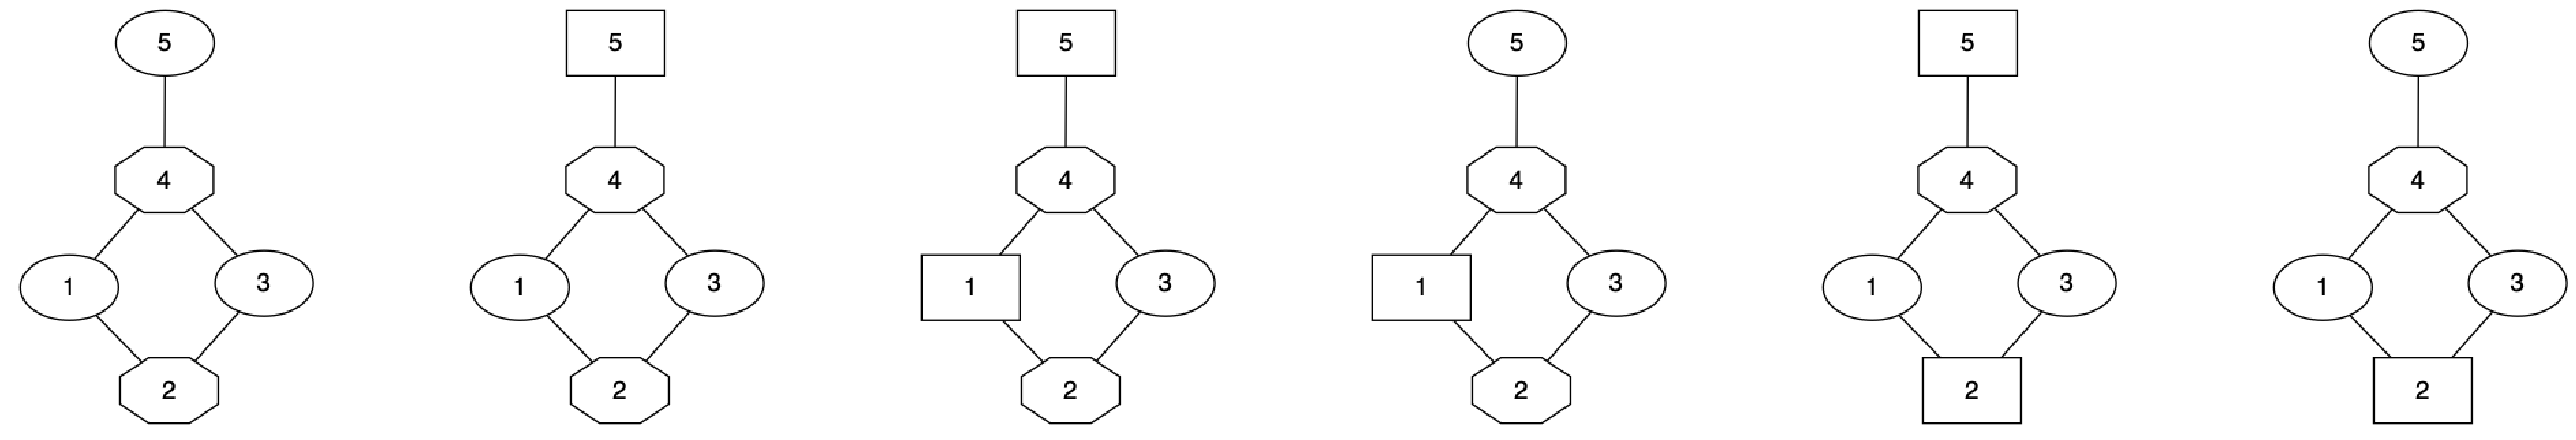

In [59]:
display_viz(vizs={i: pattern_reps[i] for i in range(len(pattern_reps))}, no_of_columns=6, figsize=(120,20))

### FUTURE WORK: Checking for equivalence in ASP (since the above methods doesn't account for the structure of the graph)

In [60]:
from PW_explorer.export import PWEExport
from PW_explorer.pwe_helper import pw_slicer, rel_slicer, pw_id_remapper

Here's how we could check if PW-21 and PW-22 are equivalent using ASP itself and some domain knowledge

In [61]:
_, temp_pws = pw_slicer(None, pw_objs, pws_to_use=[21,22])
_, _, temp_pws = rel_slicer(None, None, temp_pws, rels_to_use=['col_2'])
_, temp_pws = pw_id_remapper(None, temp_pws, pw_id_map={21:1, 22:2}, pws_inplace=False, dfs_inplace=False)
col_assignment_rules = PWEExport.export_as_asp_facts(pws=temp_pws, attr_defs=meta_data['attr_defs'])
print('\n'.join(col_assignment_rules))

% define node(PW_ID,nodeID)
% define e(PW_ID,nodeID1,nodeID2)
% define col(PW_ID,nodeID,color)
col(1,1,red).
col(1,2,blue).
col(1,3,red).
col(1,4,blue).
col(1,5,red).
col(2,1,red).
col(2,2,blue).
col(2,3,red).
col(2,4,blue).
col(2,5,green).


In [62]:
_, temp_pws = pw_slicer(None, pw_objs, pws_to_use=[21])
_, _, temp_pws = rel_slicer(None, None, temp_pws, rels_to_use=['e_2'])
edge_rules = PWEExport.export_as_asp_facts(pws=temp_pws, attr_defs=None, include_pw_ids=False)
print('\n'.join(edge_rules))

e(1,2).
e(2,3).
e(3,4).
e(4,1).
e(4,5).


In [63]:
with open('clingo_files/3col_equivalence_check.lp4') as f:
    equivalence_check_rules = list(map(str.strip, f.readlines()))
print("\n".join(equivalence_check_rules))

e(X,Y) :- e(Y,X).
node(X) :- e(X,_).
node(X) :- e(_,X).

c(X) :- col(_,_,X).

vmap(X,Y) ; vout(X,Y) :- node(X), node(Y).
:- vmap(X1,Y1), vmap(X2,Y2), e(X1,X2), not e(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not e(X1,X2), e(Y1,Y2).
used1(X) :- vmap(X,_).
:- node(X), not used1(X).
:- vmap(X,Y),vmap(X,Z),Y!=Z.
:- vmap(Y,X),vmap(Z,X),Y!=Z.

cmap(X,Y) ; cout(X,Y) :- c(X), c(Y).
usedc(X) :- cmap(X,_).
:- c(X), not usedc(X).
:- cmap(X,Y), cmap(X, Z), Y!=Z.
:- cmap(X,Y), vmap(V1, V2), col(1, V1, X), not col(2, V2, Y).
:- cmap(X,Y), vmap(V1, V2), not col(1, V1, X), col(2, V2, Y).

#show vmap/2.
#show cmap/2.


In [64]:
eq_check_soln, _ = run_clingo(clingo_rules=col_assignment_rules+edge_rules+equivalence_check_rules)
print('\n'.join(eq_check_soln))

UNSATISFIABLE

Models       : 0
Calls        : 1
Time         : 0.004s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)
CPU Time     : 0.004s


##### Since it's unsatisfiable, the two must not be equivalent.

Converting this into a distance function

In [65]:
def asp_3col_equivalence_check(pws, edge_rules, eq_check_rules, pw_id_1, pw_id_2):
    _, temp_pws = pw_slicer(None, pw_objs, pws_to_use=[pw_id_1,pw_id_2])
    _, _, temp_pws = rel_slicer(None, None, temp_pws, rels_to_use=['col_2'])
    _, temp_pws = pw_id_remapper(None, temp_pws, pw_id_map={pw_id_1:1, pw_id_2:2}, 
                                 pws_inplace=False, dfs_inplace=False)
    col_assignment_rules = PWEExport.export_as_asp_facts(pws=temp_pws, attr_defs=None, include_pw_ids=True)
    
    eq_check_soln, _ = run_clingo(clingo_rules=col_assignment_rules+edge_rules+eq_check_rules)
    t_dfs, t_rels, t_pws = load_worlds(asp_output=eq_check_soln, meta_data=None, reasoner='clingo')
    if len(t_pws) > 0:
        return 0
    return 1

In [66]:
_, temp_pws = pw_slicer(None, pw_objs, pws_to_use=[1])
_, _, temp_pws = rel_slicer(None, None, temp_pws, rels_to_use=['e_2'])
EDGE_FACTS = PWEExport.export_as_asp_facts(pws=temp_pws, attr_defs=None, include_pw_ids=False)

with open('clingo_files/3col_equivalence_check.lp4') as f:
    EQUIVALENCE_CHECK_RULES = list(map(str.strip, f.readlines()))

Creating a distance matrix using the above check

In [67]:
dist_matrix = np.zeros((len(pw_objs), len(pw_objs)))
for i in range(len(pw_objs)):
    for j in range(i+1, len(pw_objs)):
        dist_matrix[i][j] = dist_matrix[j][i] = asp_3col_equivalence_check(pw_rel_dfs, EDGE_FACTS, 
                                                                           EQUIVALENCE_CHECK_RULES, i+1, j+1) + 1
dist_matrix

Number of Models: 1
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 1
Number of Models: 1
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 1
Number of Models: 1
Number of Models: 1
Number of Models: 1
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiabl

The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The probl

The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of

The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
The problem is unsatisfiable
Number of Models: 0
Number of Models: 2
The probl

array([[0., 1., 2., ..., 2., 1., 1.],
       [1., 0., 2., ..., 2., 1., 1.],
       [2., 2., 0., ..., 1., 2., 2.],
       ...,
       [2., 2., 1., ..., 0., 2., 2.],
       [1., 1., 2., ..., 2., 0., 1.],
       [1., 1., 2., ..., 2., 1., 0.]])

Hmm, maybe we should add a 'silent' option in the next iteration of PWE.

It's in the pipeline, track progress here: https://github.com/idaks/PW-explorer/issues/20

#### On clustering these, we get the 5 clusters we were looking for.

/Users/sahil1105/PW-explorer/.env/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


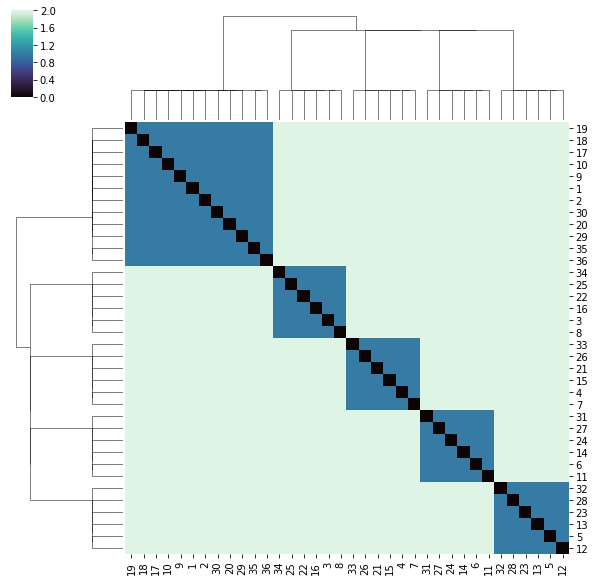

In [68]:
_ = cluster_map_viz(dist_matrix)

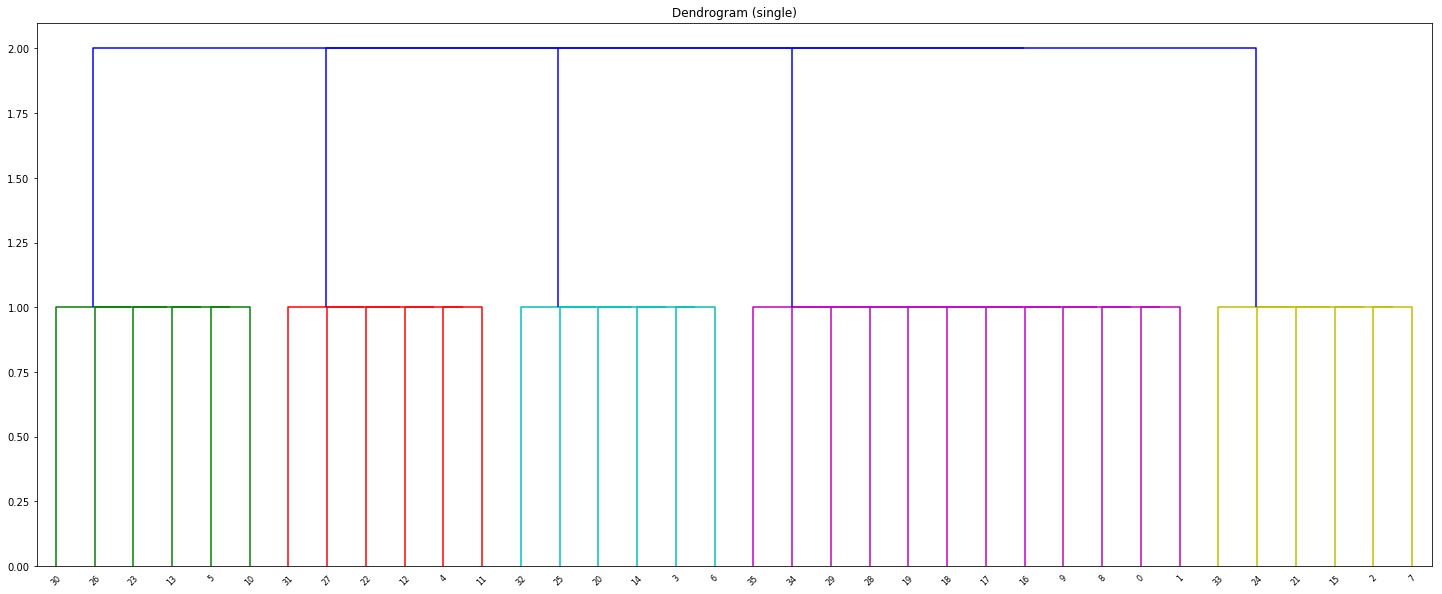

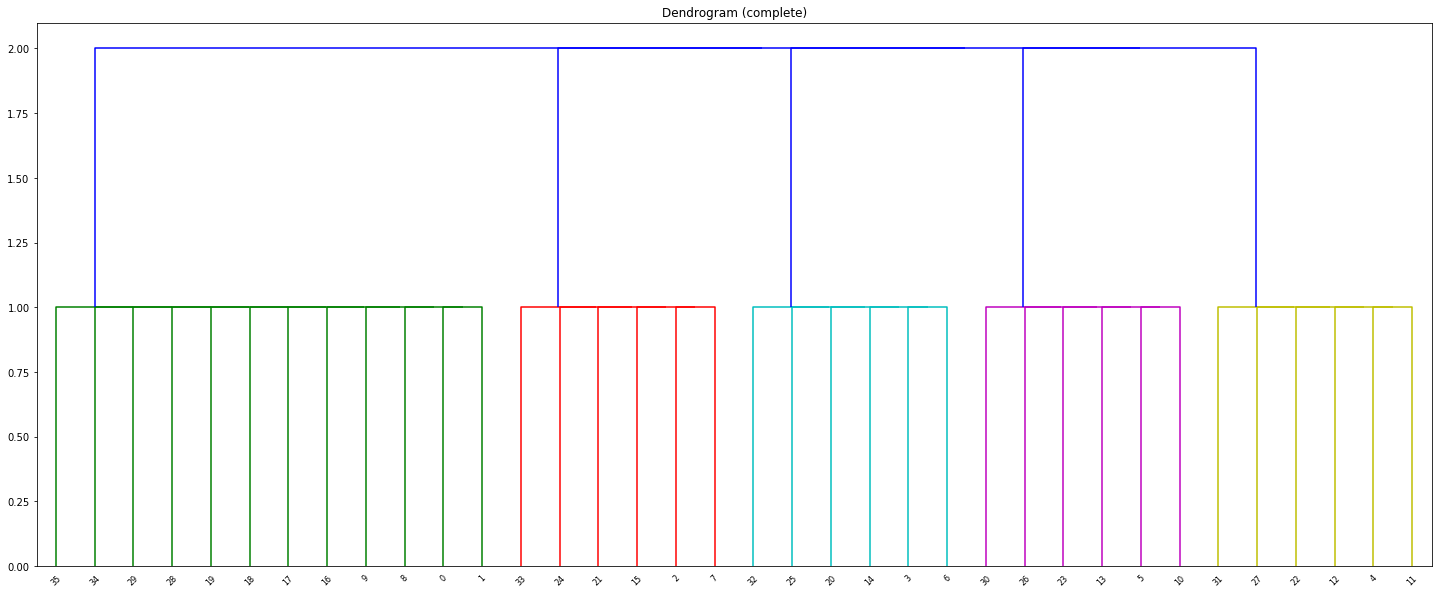

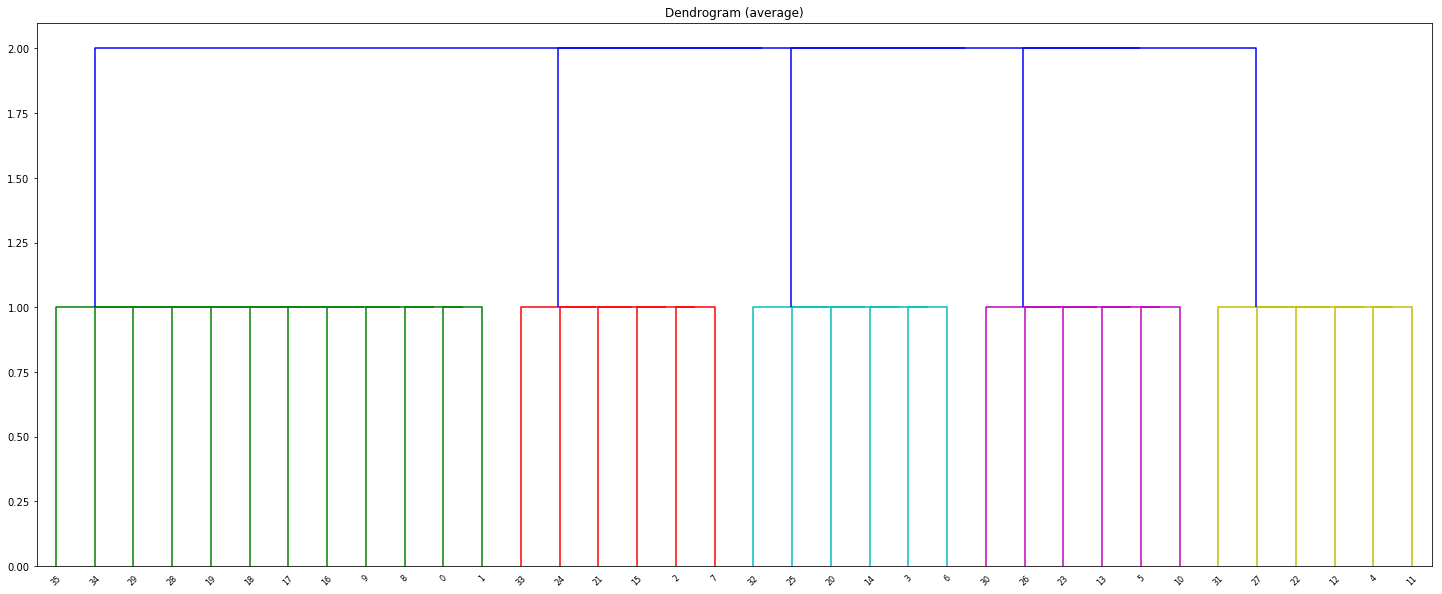

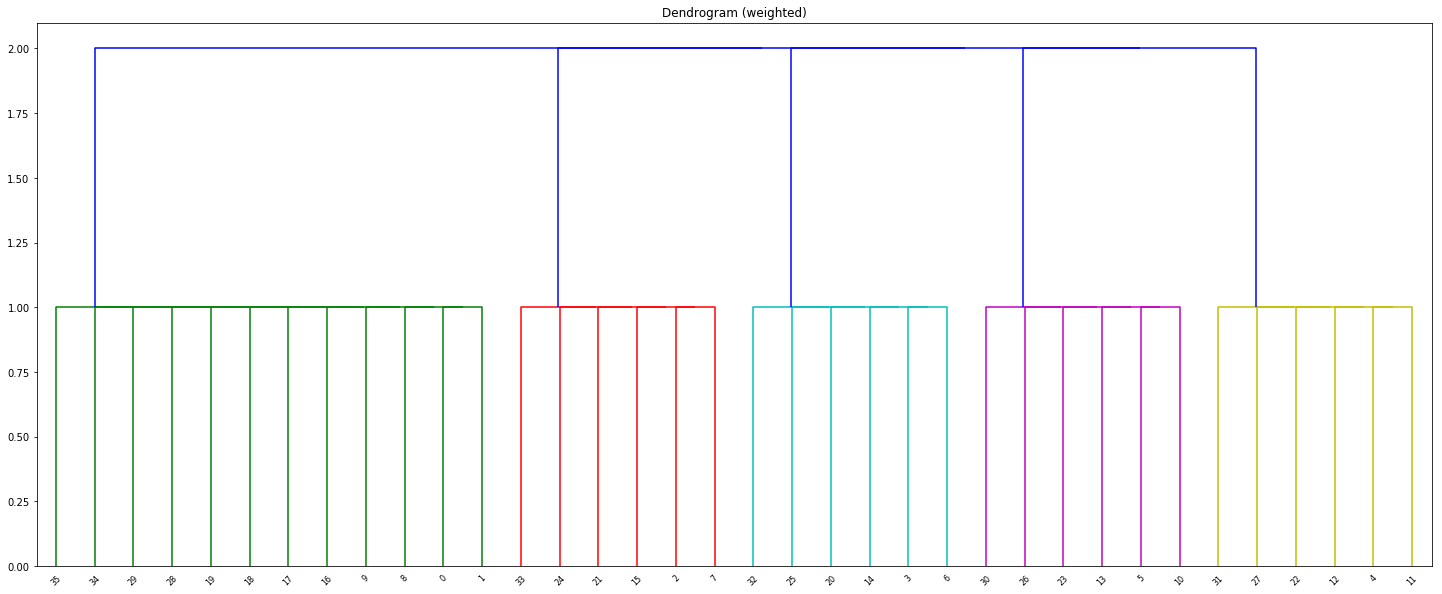

In [69]:
_ = PWEVisualization.linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

These are almost the same clusters as before, however, this time, CLUSTER 3 and CLUSTER 4 are part of the same cluster, which is what we wanted.